In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from sklearn.svm import SVC,LinearSVC
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import seaborn as sns
torch.manual_seed(12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Generate dataset

In [2]:
y = np.random.randint(0,3,150)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 52
1 55
2 43


In [0]:
x = np.zeros((150,2))
# x1 = np.zeros((500,2))

In [0]:
# x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
# x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
# x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))
# x[idx[3],:] = np.random.normal(loc = 3)


In [0]:
x[idx[0]] = np.random.uniform(low =[-1.5,1],high =[-1,2],size= (sum(idx[0]),2))
x[idx[2]] = np.random.uniform(low =[-1.5,3],high =[-1,4],size= (sum(idx[2]),2))
x[idx[1]] = np.random.uniform(low =[0.5,2],high =[1,3],size= (sum(idx[1]),2))


In [5]:
# x,y = np.concatenate((x,x1),axis=0),np.concatenate((y,y),axis=0)
x.shape,y.shape

((150, 2), (150,))

# Visualise Data Distribution

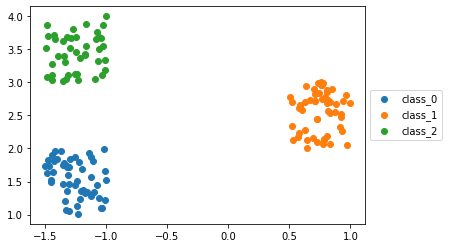

In [6]:
for i in range(3):
    #y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
foreground_classes = {'class_0','class_1'}

background_classes = {'class_2'}

In [8]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,3)
bg_class = 2
a = []
for i in range(3):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
#print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
foreground 0 present at 1
background 2 present at 2
0 1


In [9]:
a

array([[-1.33763354,  3.30837443],
       [-1.49894973,  1.72805584],
       [-1.43232712,  3.71242875]])

In [0]:
desired_num = 1000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,3)
    bg_class = 2
    a = []
    for i in range(3):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(6,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [11]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
print(mosaic_list)

[[-1.06346839  3.50358851 -1.44668239  3.27726733 -1.11003846  1.81109141]
 [-1.06346839  3.50358851 -1.35327868  3.01019631  0.52155955  2.33664107]
 [-1.31382968  3.10408643 -1.18451994  1.3593375  -1.06540851  3.31657764]
 ...
 [ 0.851157    2.9003593  -1.01201801  3.33185975 -1.06346839  3.50358851]
 [-1.35793104  1.46718924 -1.35327868  3.01019631 -1.44333761  3.02825708]
 [-1.01201801  3.33185975  0.91306181  2.3214829  -1.0346593   3.09970936]]


In [12]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(1000,)
(1000,)


In [13]:
mosaic_list[:,0:2].shape

(1000, 2)

In [0]:
class MosaicDataset(Dataset):
    """MosaicDataset dataset."""
    
    
    def __init__(self, mosaic_list, mosaic_label, fore_idx):
        """
          Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.mosaic = mosaic_list
        self.label = mosaic_label
        self.fore_idx = fore_idx

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=False)

In [0]:
class Wherenet(nn.Module):
    def __init__(self,batch):
        super(Wherenet,self).__init__()
        self.batch = batch
        self.linear1 = nn.Linear(2,1)
    def forward(self,z):
        x = torch.zeros([self.batch,3],dtype=torch.float64)
        y = torch.zeros([self.batch,2], dtype=torch.float64)
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(3):
            x[:,i] = self.helper(z[:,2*i:2*i+2])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        
        x = F.softmax(x,dim=1)   # alphas
        #print(x.shape)
        x1 = x[:,0]
        for i in range(3):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],z[:,2*i:2*i+2])
        return  y , x 

    
    def helper(self,x):
        x = self.linear1(x)
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)
        
        return x


In [0]:
where = Wherenet(batch).double()

In [0]:
def focus_map(focus_net):
  plt.figure(figsize=(6,6))
  X,Y = torch.meshgrid(torch.linspace(-1.5,1,100), torch.linspace(1,4,100))
  n=X.shape[0]*X.shape[1]
  data = torch.zeros((n,2)).double()
  data[:,0]=X.reshape((-1,))
  data[:,1]=Y.reshape((-1,))
  Z = []
  iter = data.shape[0]//batch
  for i in range(iter):
    #print(data[i*batch:(i+1)*batch].shape)
    Z_ = focus_net.helper(data[i*batch:(i+1)*batch]).detach().numpy()
    Z.append(Z_)
  Z = np.concatenate(Z,axis=0)
  Z = Z.reshape(X.shape)
  plt.title("focus_map")
  plt.contourf(X,Y,Z,)
  plt.colorbar()

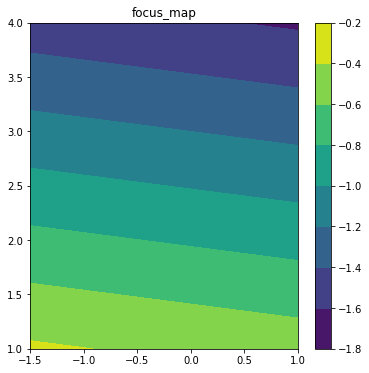

In [18]:
focus_map(where)

In [0]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,2)
#         self.linear2 = nn.Linear(8,16)
#         self.linear3 = nn.Linear(16,3)
    def forward(self,x):
        x = self.linear1(x)
#         x = F.relu(self.linear2(x))
#         x = self.linear3(x)
        return x

In [0]:
what =Whatnet().double()


In [0]:
def classification_map(class_net):
  plt.figure(figsize=(6,6))
  X,Y = torch.meshgrid(torch.linspace(-1.5,1,100), torch.linspace(1,4,100))
  n=X.shape[0]*X.shape[1]
  data = torch.zeros((n,2)).double()
  data[:,0]=X.reshape((-1,))
  data[:,1]=Y.reshape((-1,))
  Z = []
  iter = data.shape[0]//batch
  for i in range(iter):
    #print(data[i*batch:(i+1)*batch].shape)
    Z_ = class_net(data[i*batch:(i+1)*batch]).detach().numpy()
    Z.append(Z_)
  Z = np.concatenate(Z,axis=0)
  Z1 = Z[:,0].reshape(X.shape)
  Z2 = Z[:,1].reshape(X.shape)
  plt.title("classification map 1")
  plt.contourf(X,Y,Z1)
  plt.colorbar()
  plt.figure(figsize=(6,6))
  plt.title("classification map 2")
  plt.contourf(X,Y,Z2)
  plt.colorbar()

In [0]:
X = []
Y = []
for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
        
    X.append(inputs.numpy())
    Y.append(labels.numpy())
X = np.concatenate(X,axis=0)
Y  = np.concatenate(Y,axis=0)

In [0]:
clf = LinearSVC(C = 10000)

In [24]:
clf.fit(X,Y)
print(clf.score(X,Y))

1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
def disp_plot(data,avg_data,true_label,pred_label,alpha,true_idx):
    plt.figure(figsize=(6,6))
    data = data.numpy()
    alpha = alpha.detach().numpy()
    avg_data = avg_data.detach().numpy()
 
    x = data[:,0:2]
    y = data[:,2:4]
    z = data[:,4:6]
    colors = ['b','g','r','c','m','y','k','teal','indigo','peru']
    
    #print(data[0],avg_data[0])
    for i in range(0,10):
        plt.plot([x[i,0],y[i,0]],[x[i,1],y[i,1]],color= colors[i])#,marker ='o-')
        plt.plot([z[i,0],y[i,0]],[z[i,1],y[i,1]],color= colors[i])#,marker ='o-')
        plt.plot([x[i,0],z[i,0]],[x[i,1],z[i,1]],color= colors[i])#,marker ='o-')
#         print("dssda",avg_data[i,0],avg_data[i,1])
#         print("aaaaa",x,y,z)
        plt.plot(avg_data[i,0], avg_data[i,1],marker="x", markersize=12, color= colors[i])
        


[1,     4] loss: 1.198
[1,    4] accuracy: 0.503
[2,     4] loss: 0.941
[2,    4] accuracy: 0.503
[3,     4] loss: 0.792
[3,    4] accuracy: 0.333
[4,     4] loss: 0.816
[4,    4] accuracy: 0.497
[5,     4] loss: 0.781
[5,    4] accuracy: 0.497


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[6,     4] loss: 0.690
[6,    4] accuracy: 0.616
[7,     4] loss: 0.642
[7,    4] accuracy: 0.503
[8,     4] loss: 0.615
[8,    4] accuracy: 0.503
[9,     4] loss: 0.569
[9,    4] accuracy: 0.601
[10,     4] loss: 0.522
[10,    4] accuracy: 0.991
[11,     4] loss: 0.484
[11,    4] accuracy: 1.000
[12,     4] loss: 0.445
[12,    4] accuracy: 1.000
[13,     4] loss: 0.401
[13,    4] accuracy: 1.000
[14,     4] loss: 0.358
[14,    4] accuracy: 1.000
[15,     4] loss: 0.318
[15,    4] accuracy: 1.000
[16,     4] loss: 0.279
[16,    4] accuracy: 1.000
[17,     4] loss: 0.244
[17,    4] accuracy: 1.000
[18,     4] loss: 0.213
[18,    4] accuracy: 1.000
[19,     4] loss: 0.186
[19,    4] accuracy: 1.000
[20,     4] loss: 0.164
[20,    4] accuracy: 1.000
[21,     4] loss: 0.145
[21,    4] accuracy: 1.000
[22,     4] loss: 0.130
[22,    4] accuracy: 1.000
[23,     4] loss: 0.117
[23,    4] accuracy: 1.000
[24,     4] loss: 0.106
[24,    4] accuracy: 1.000
[25,     4] loss: 0.097
[25,    4] accu

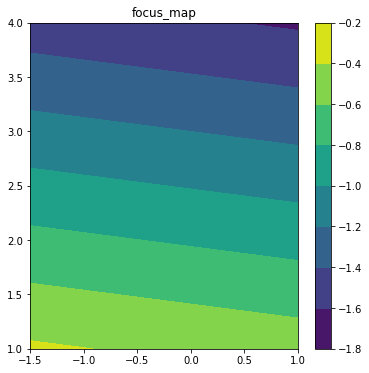

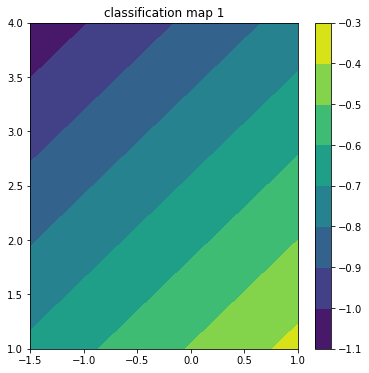

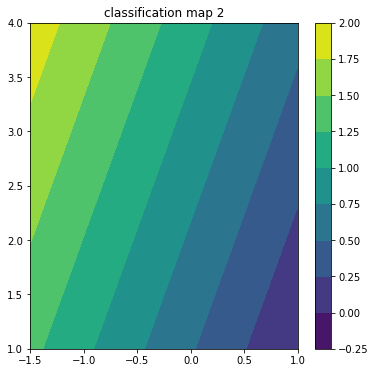

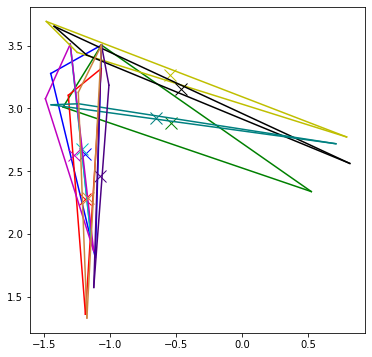

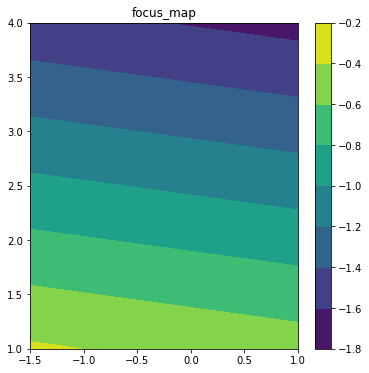

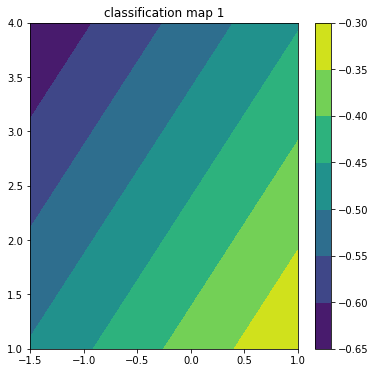

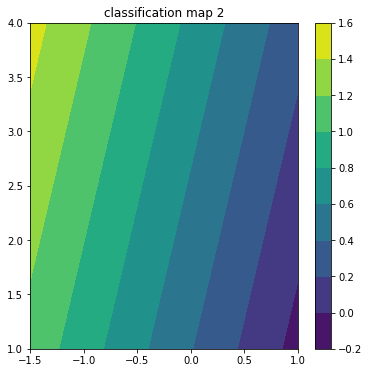

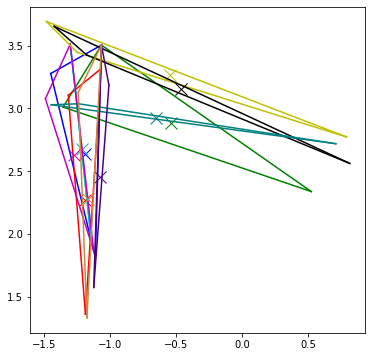

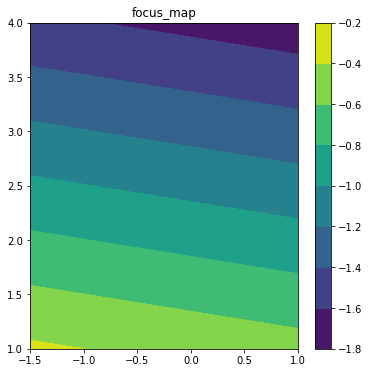

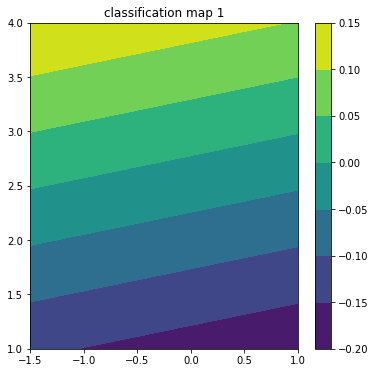

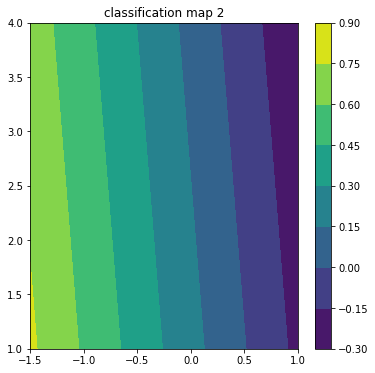

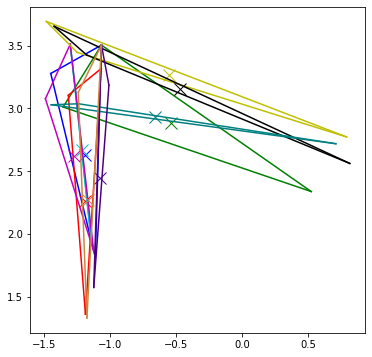

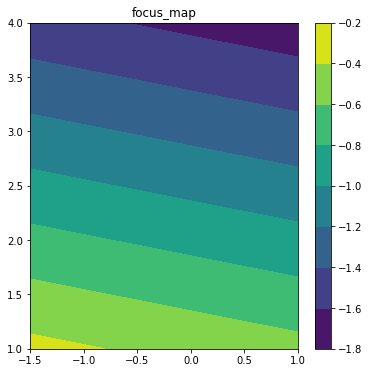

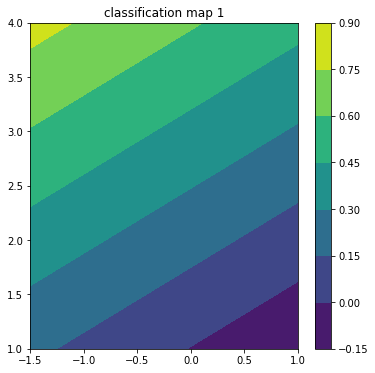

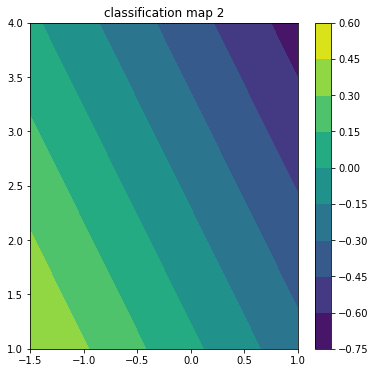

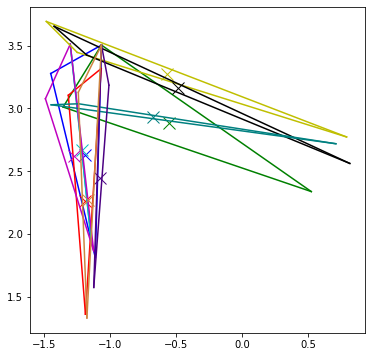

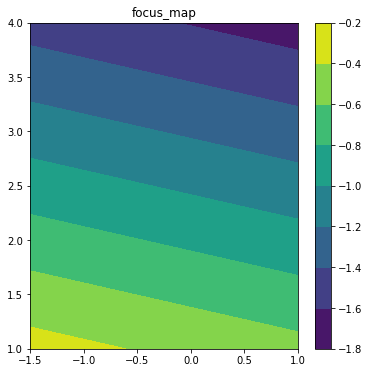

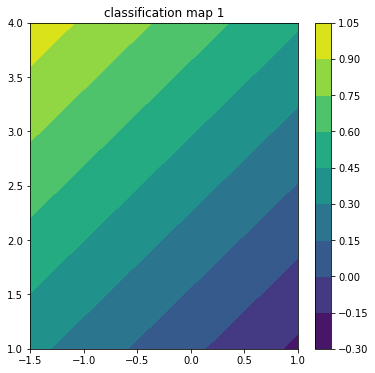

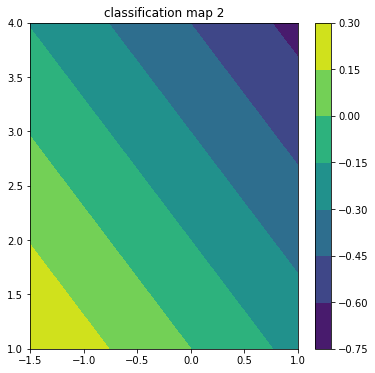

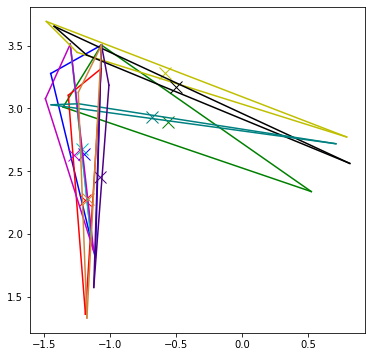

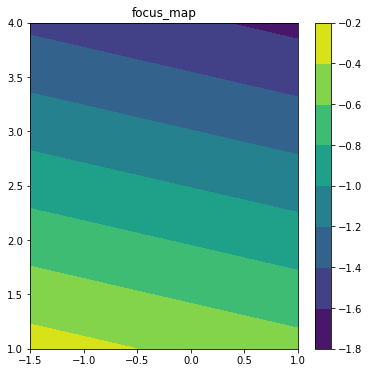

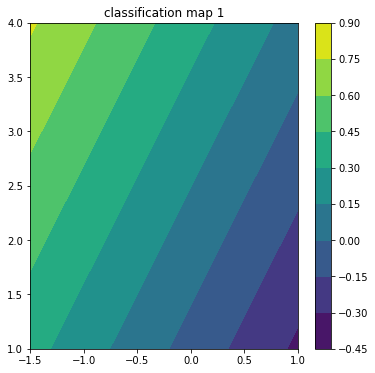

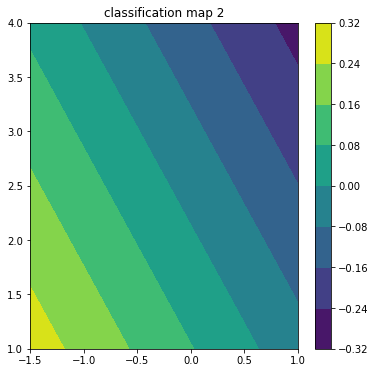

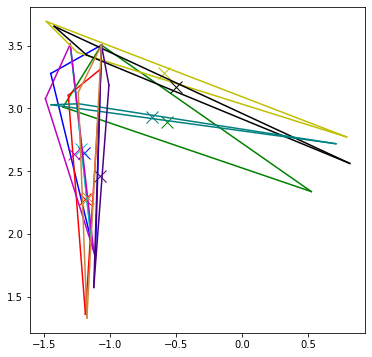

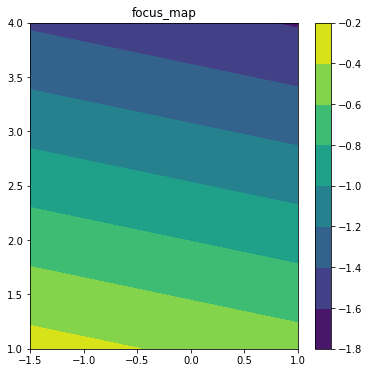

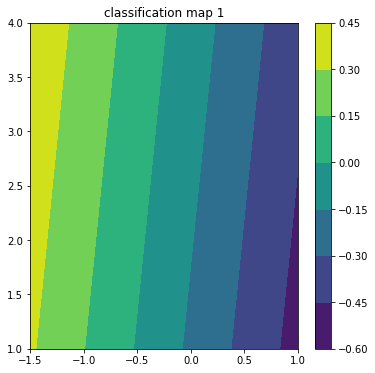

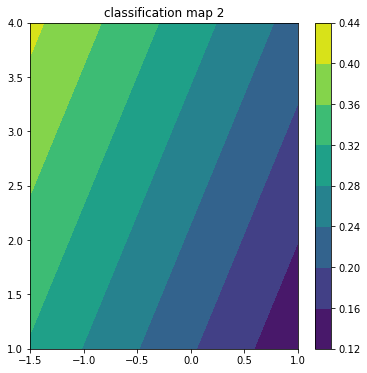

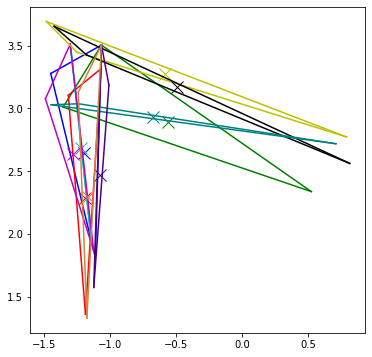

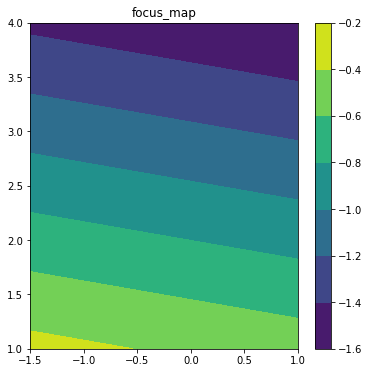

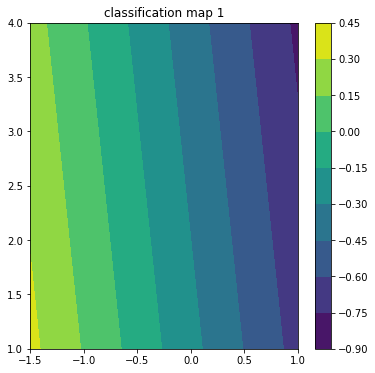

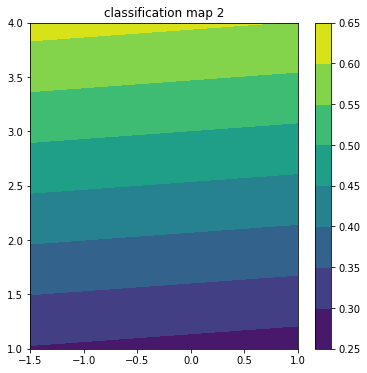

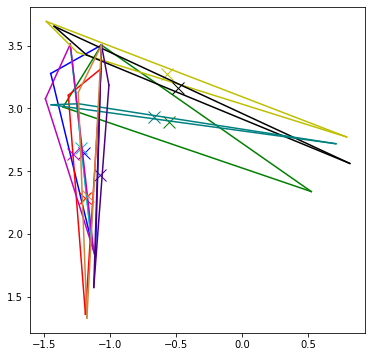

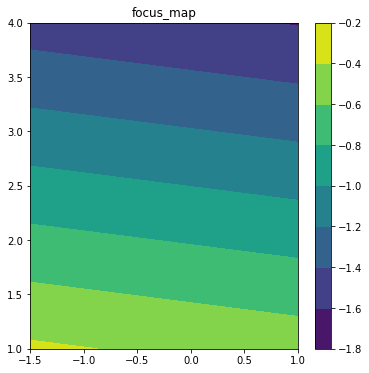

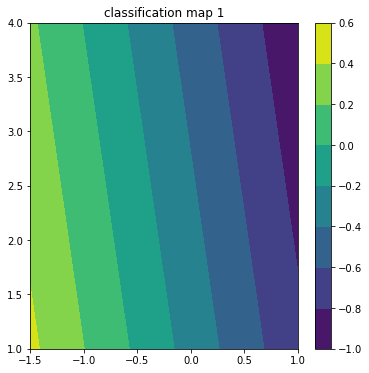

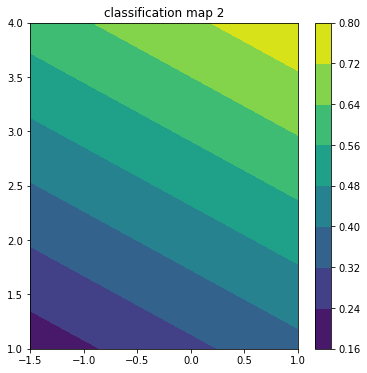

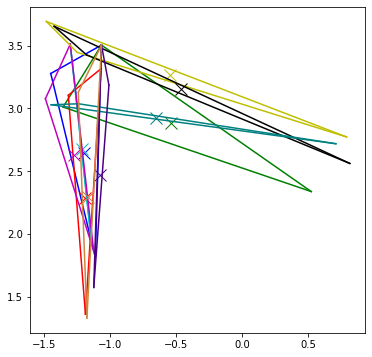

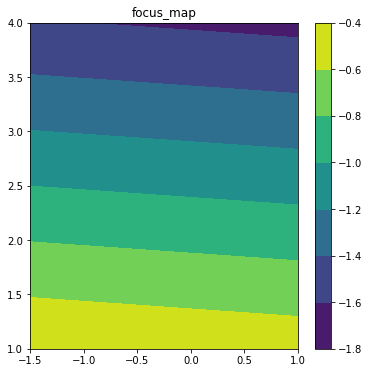

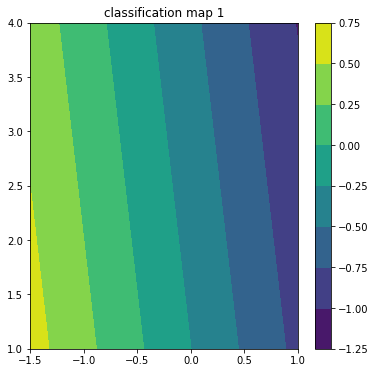

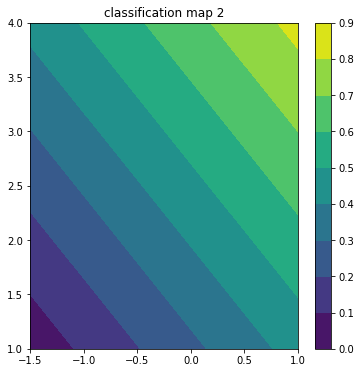

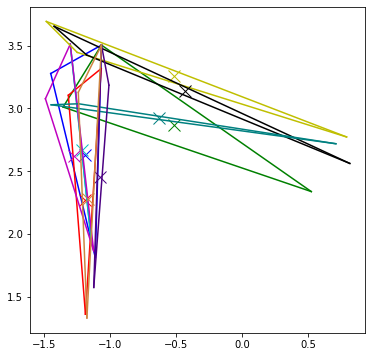

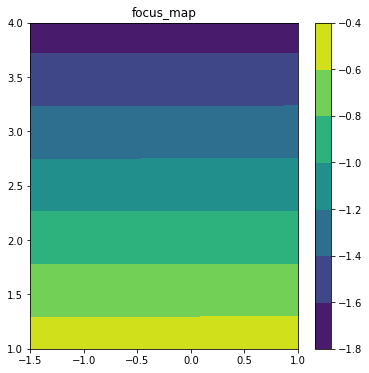

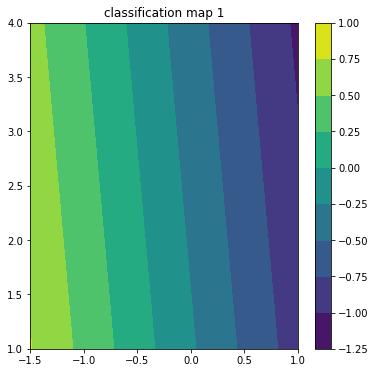

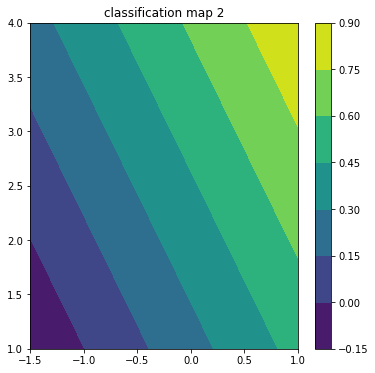

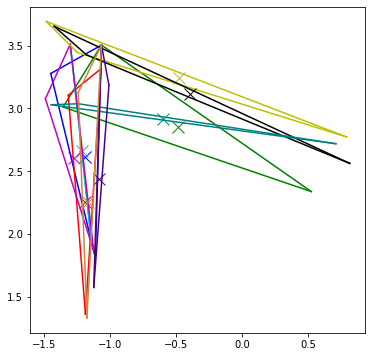

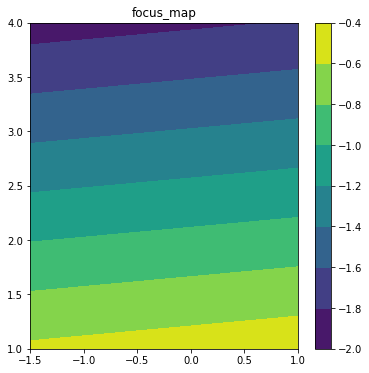

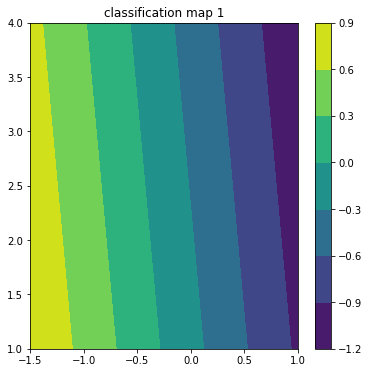

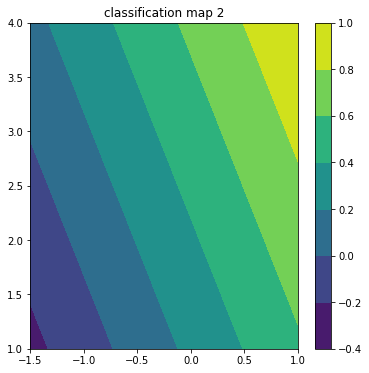

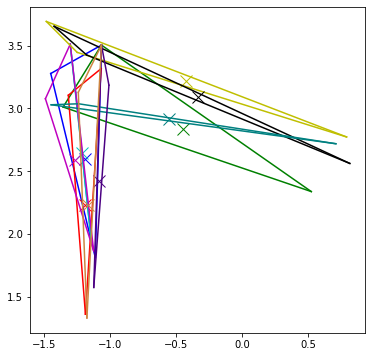

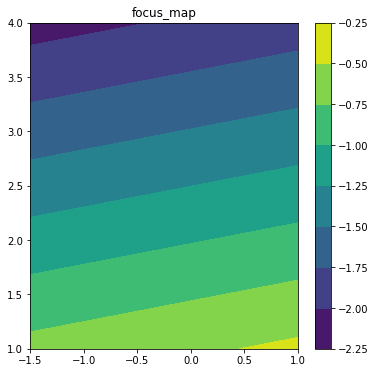

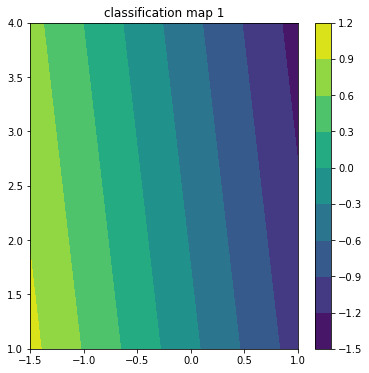

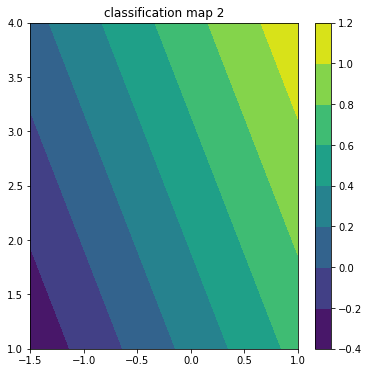

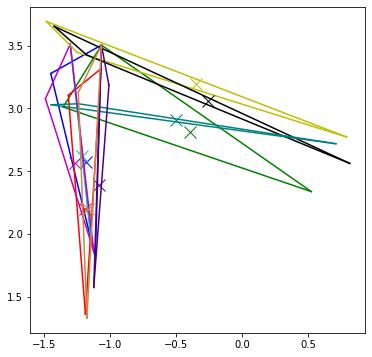

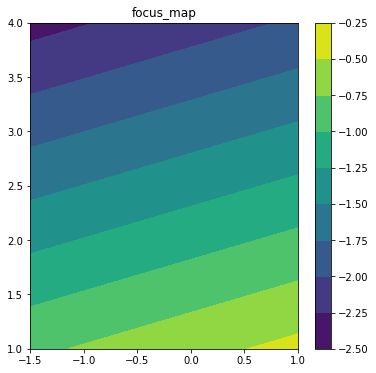

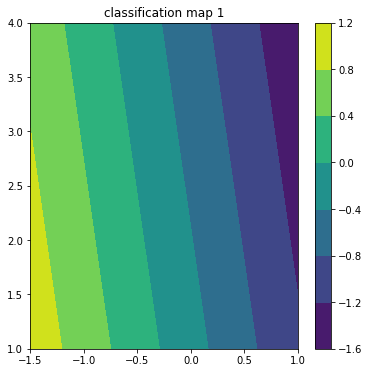

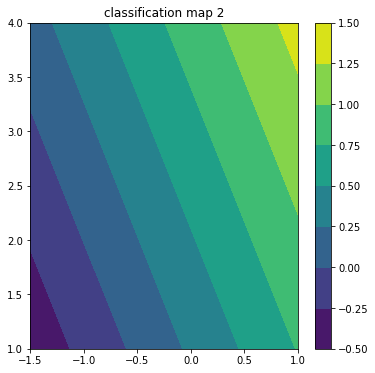

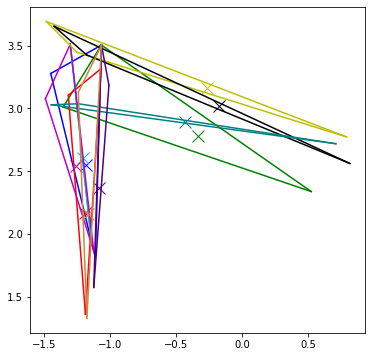

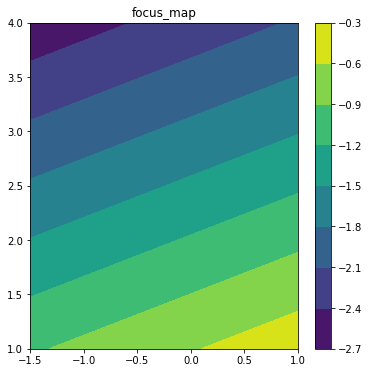

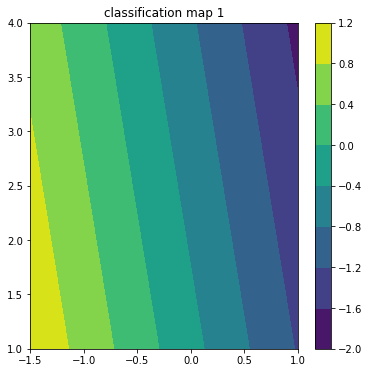

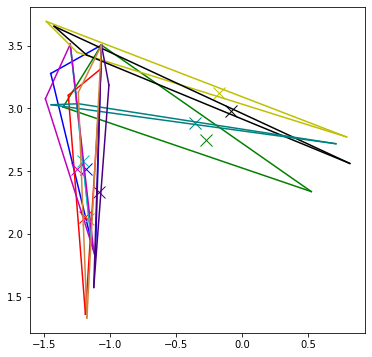

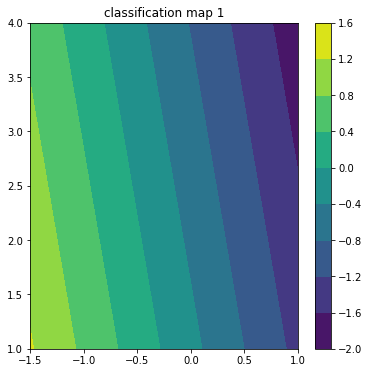

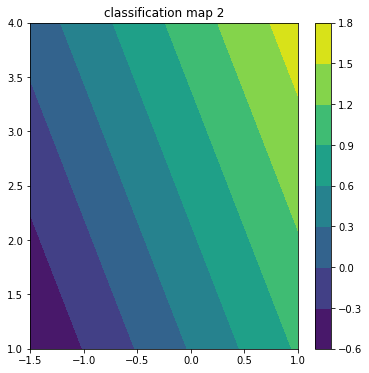

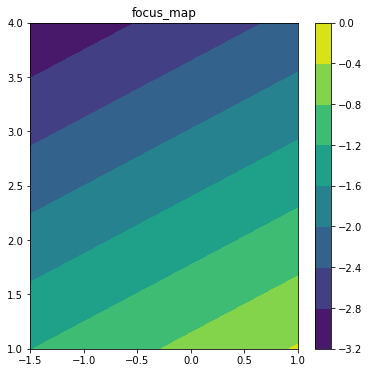

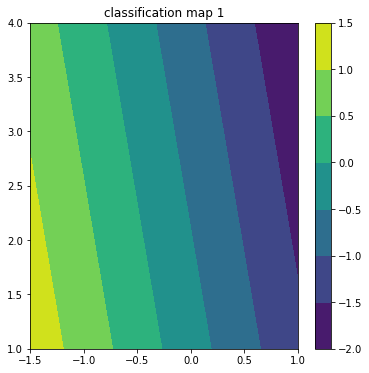

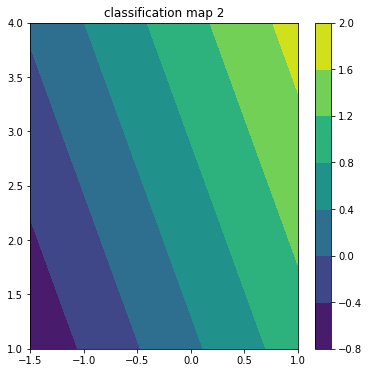

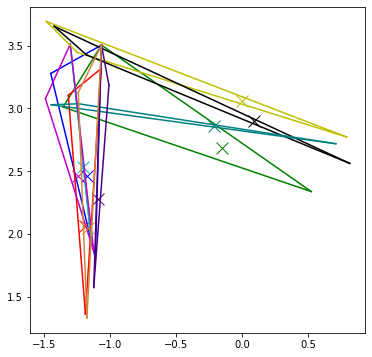

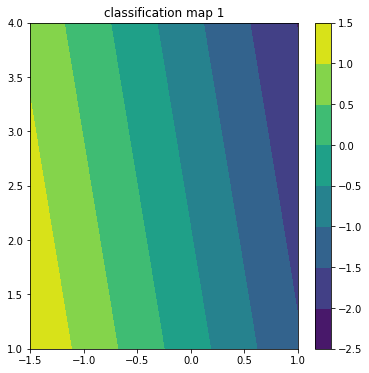

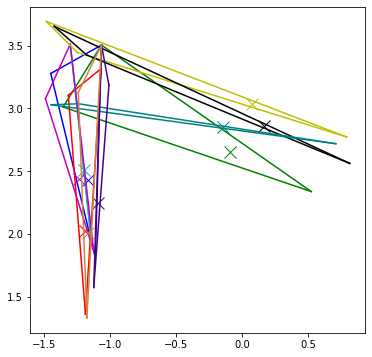

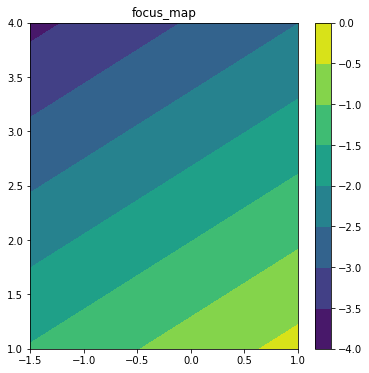

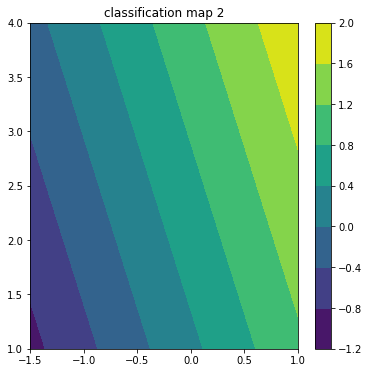

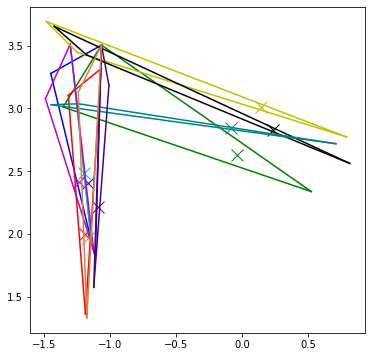

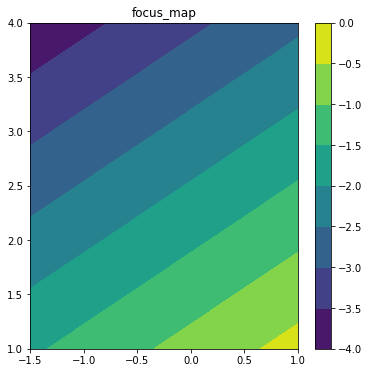

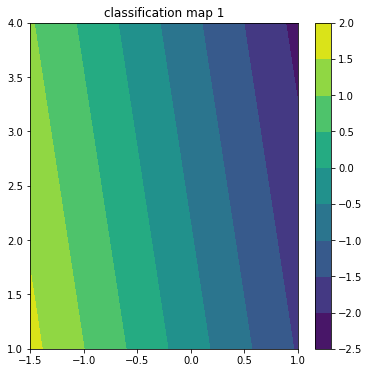

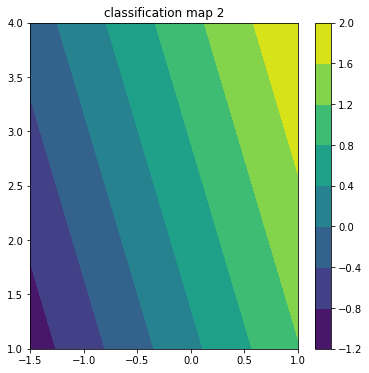

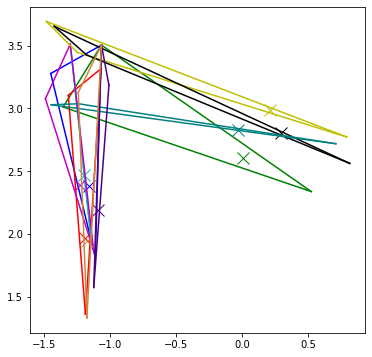

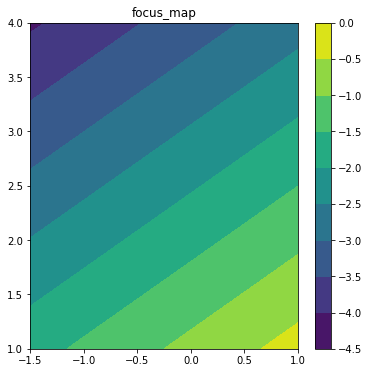

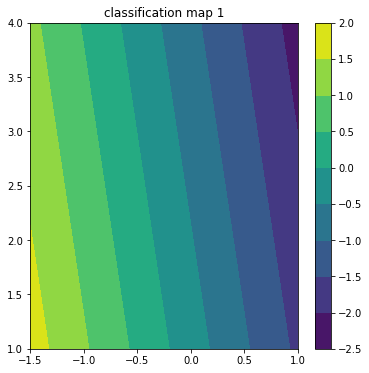

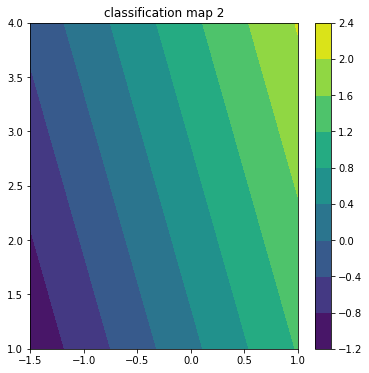

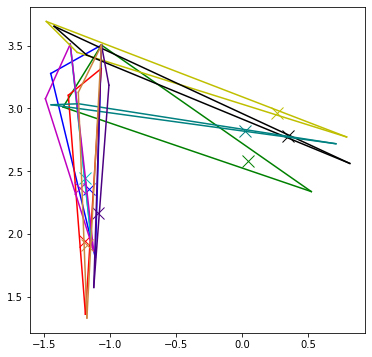

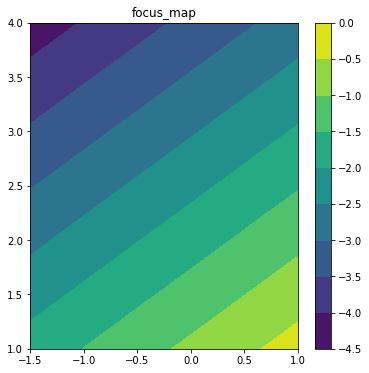

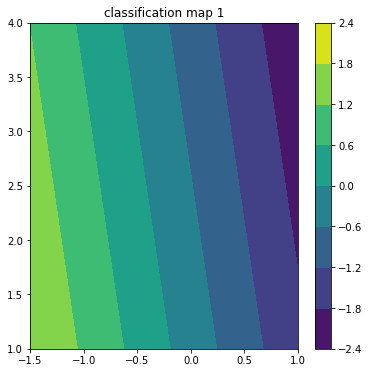

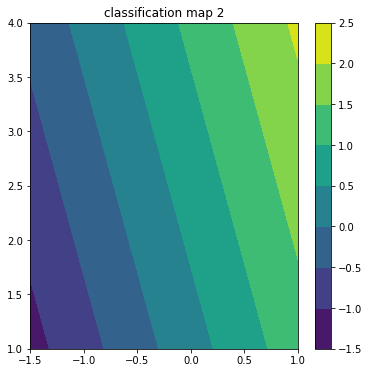

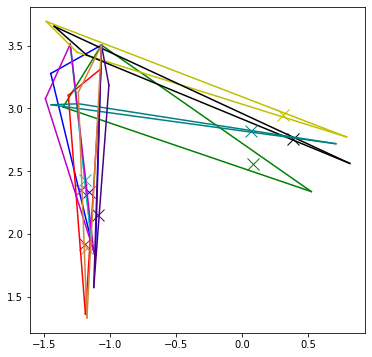

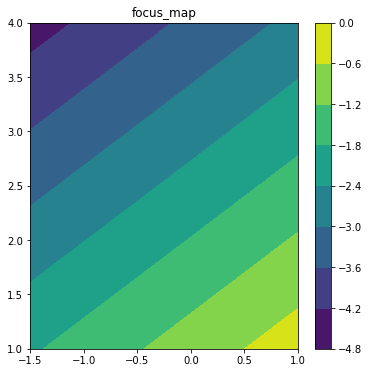

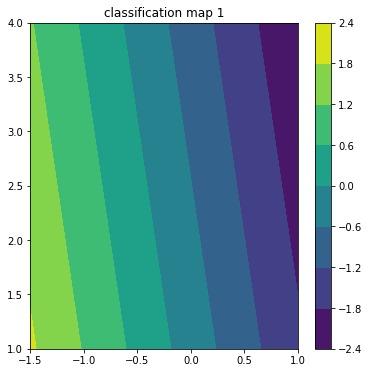

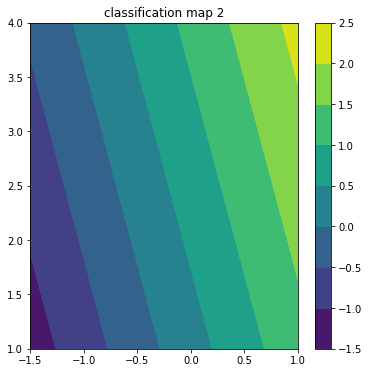

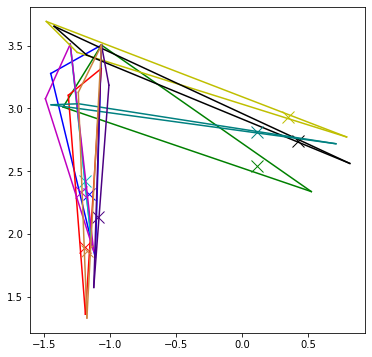

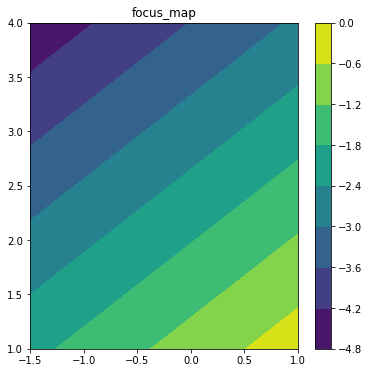

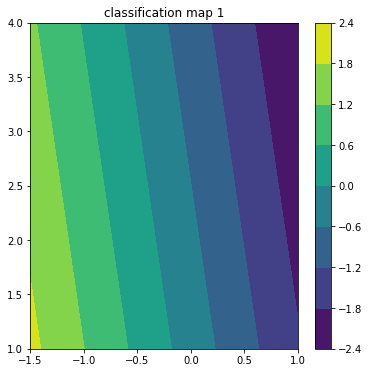

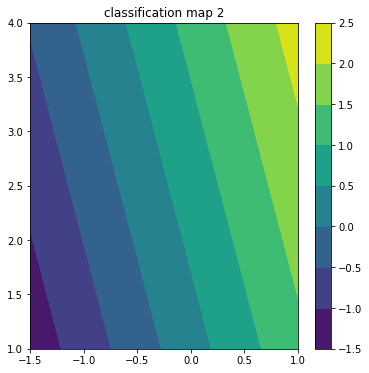

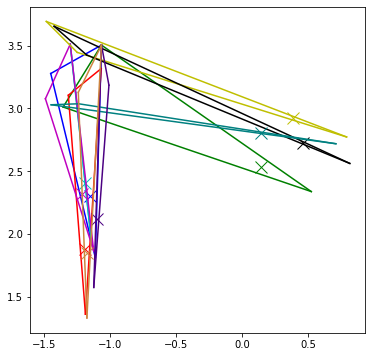

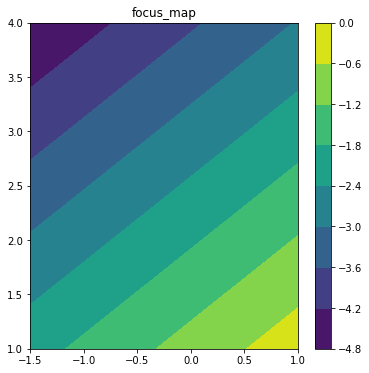

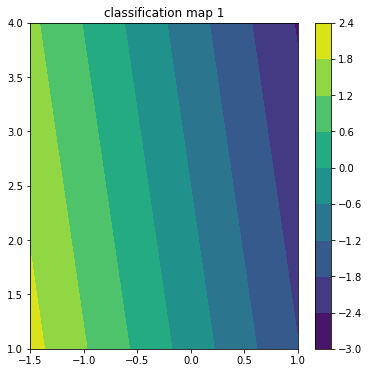

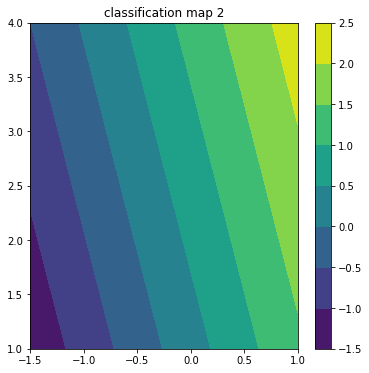

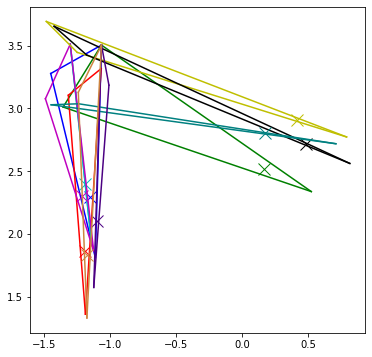

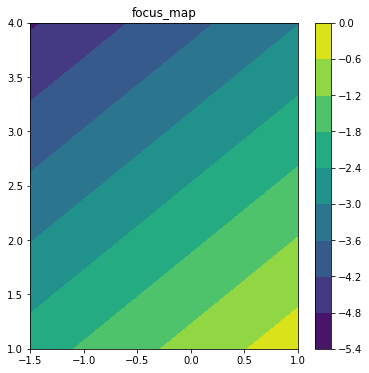

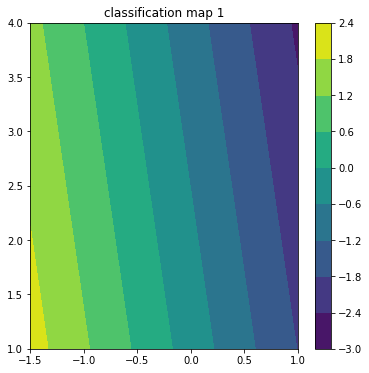

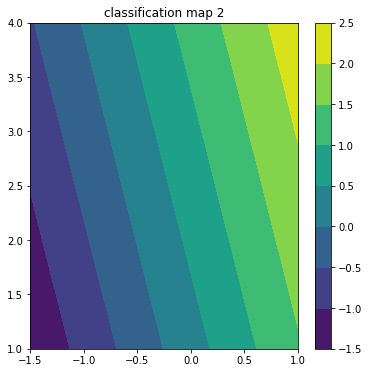

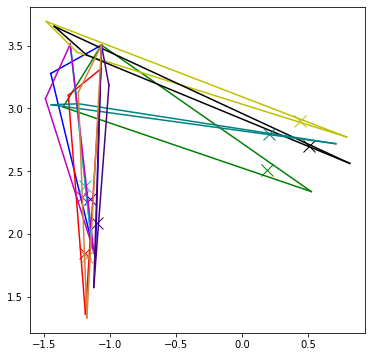

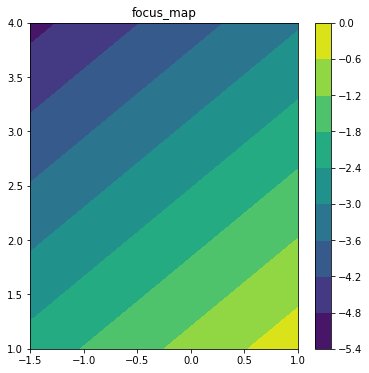

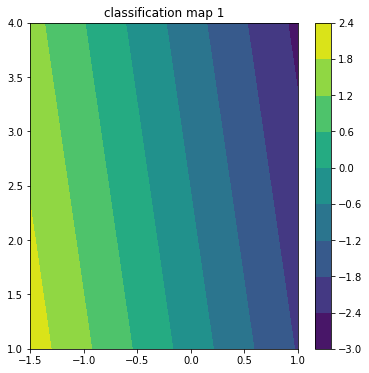

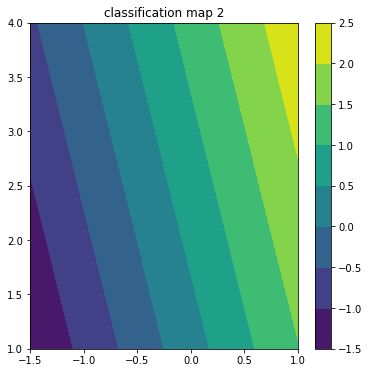

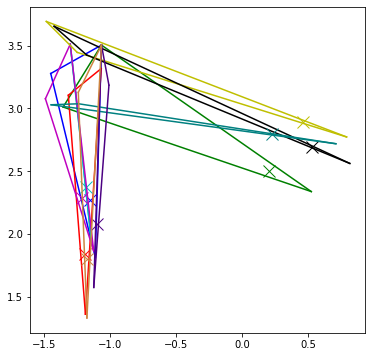

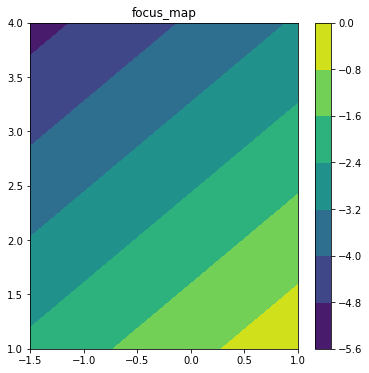

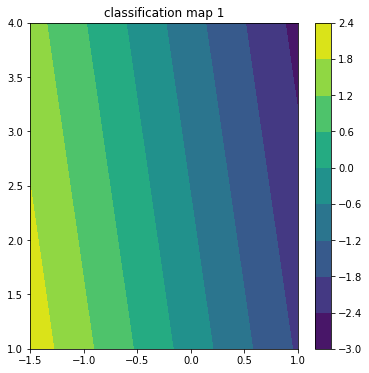

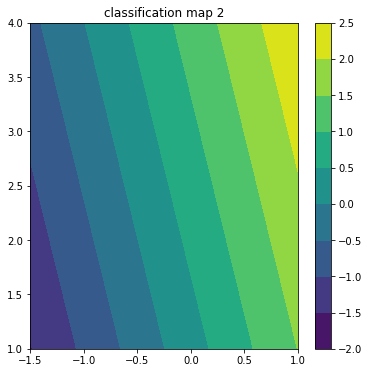

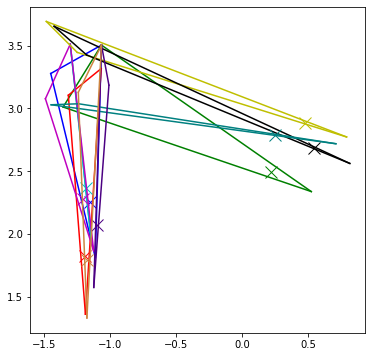

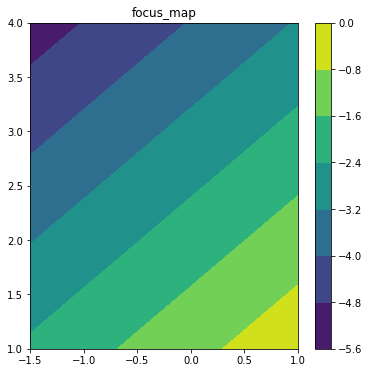

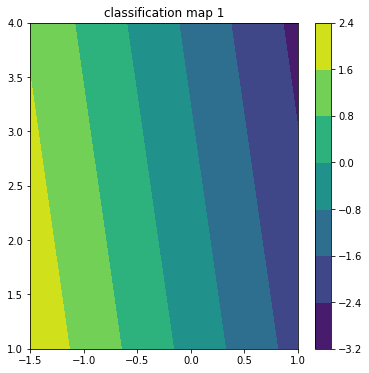

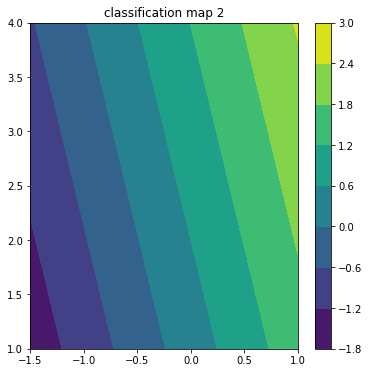

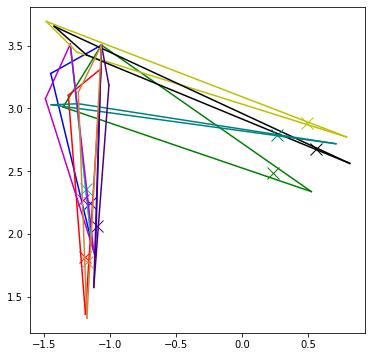

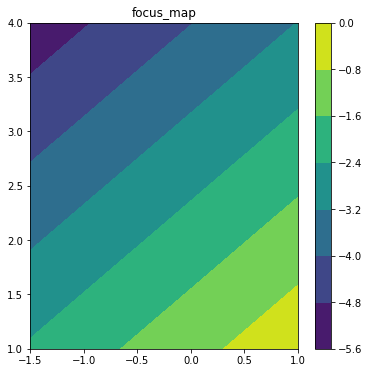

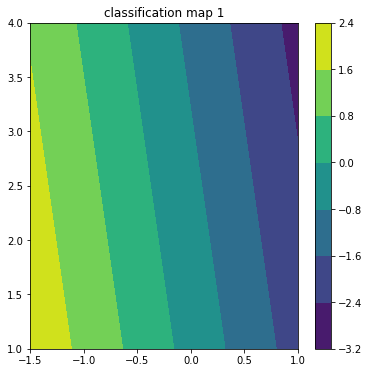

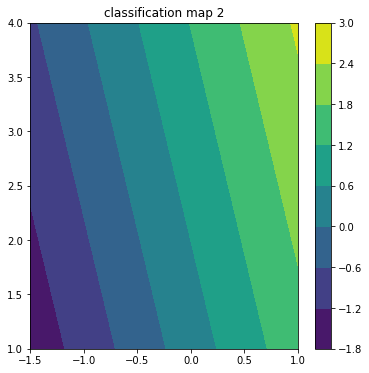

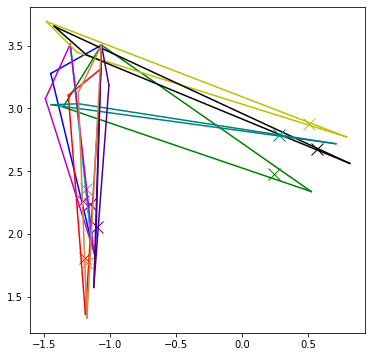

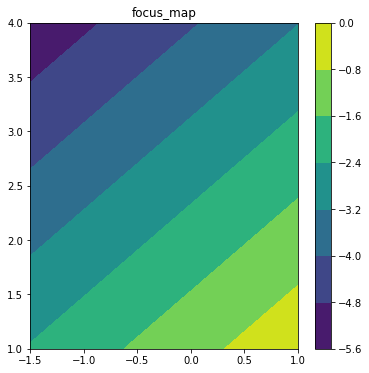

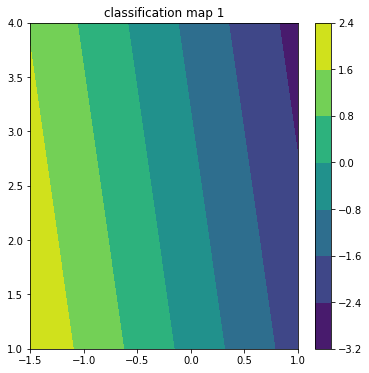

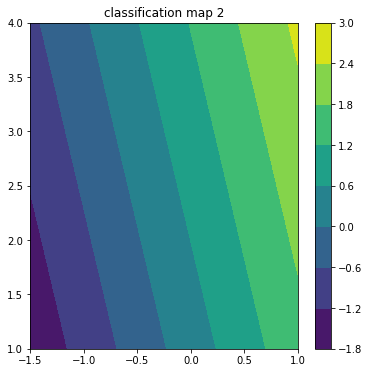

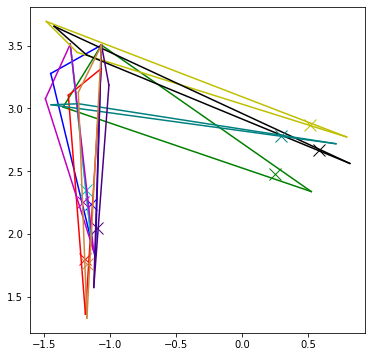

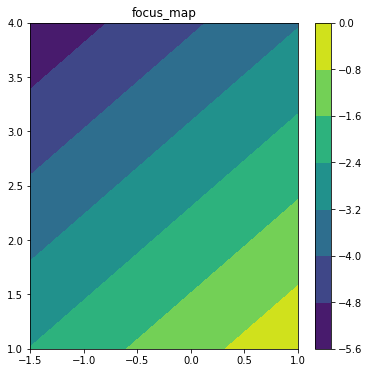

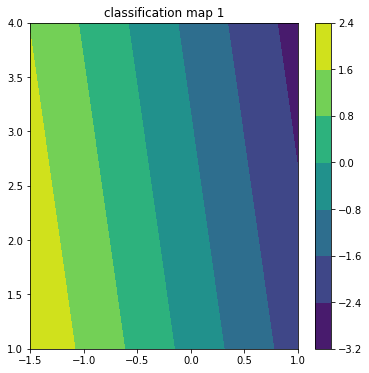

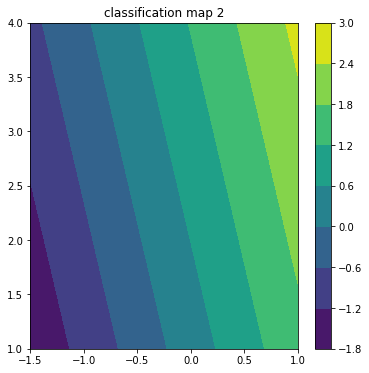

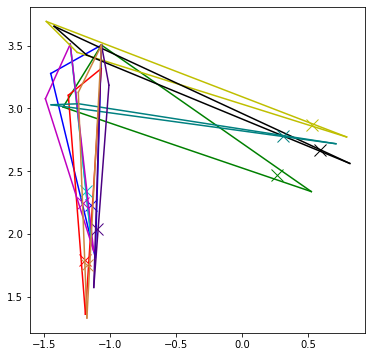

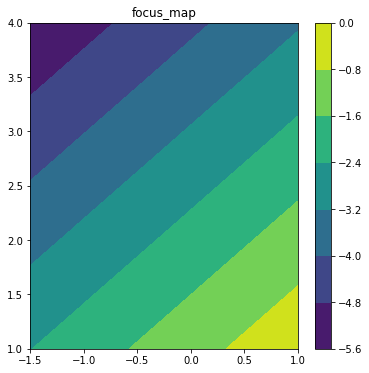

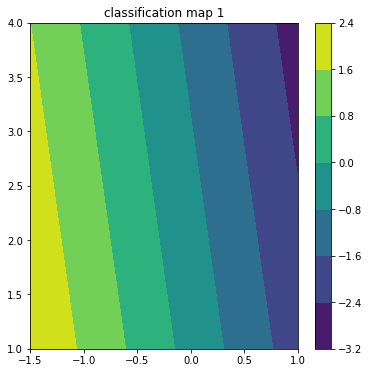

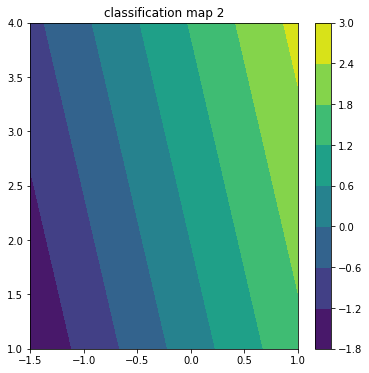

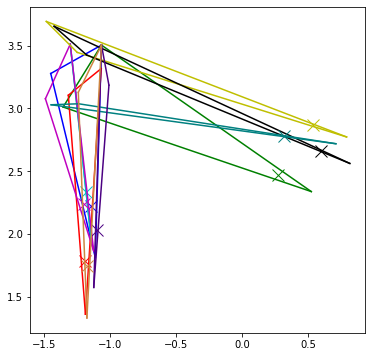

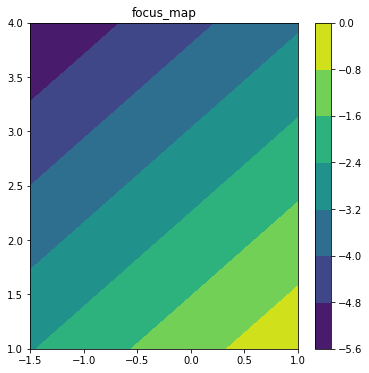

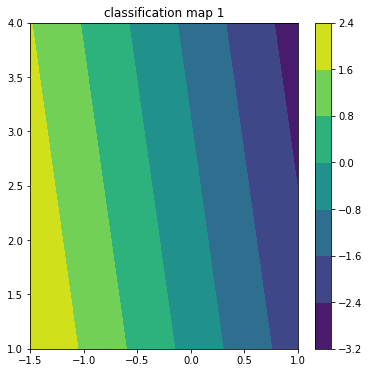

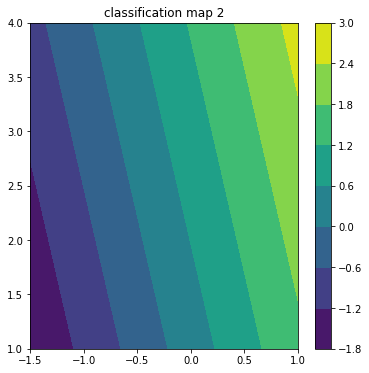

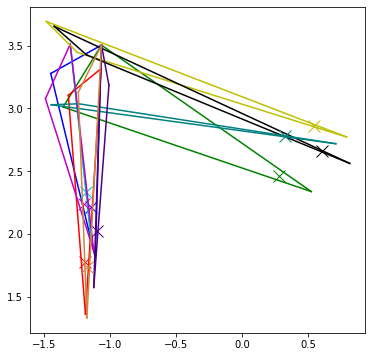

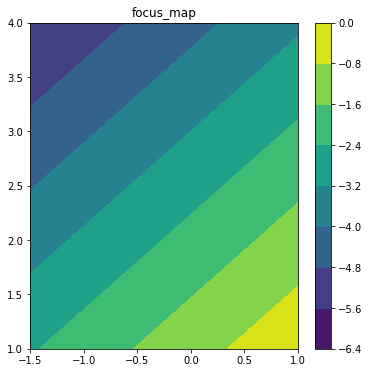

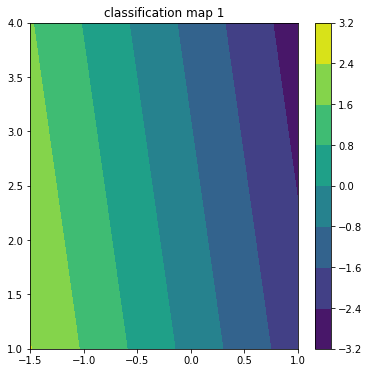

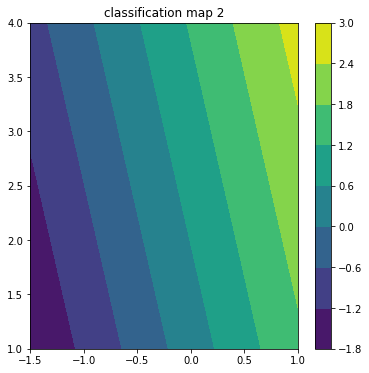

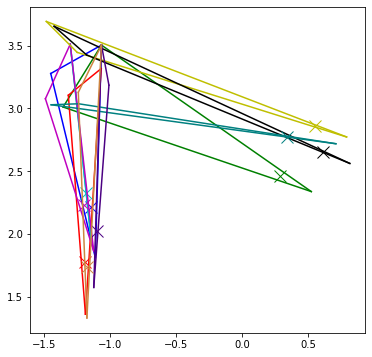

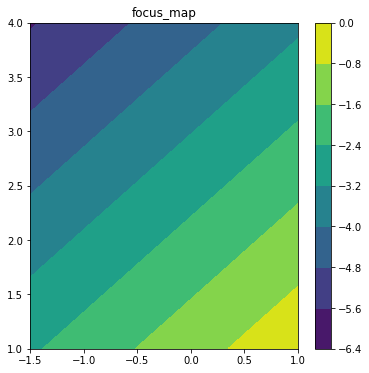

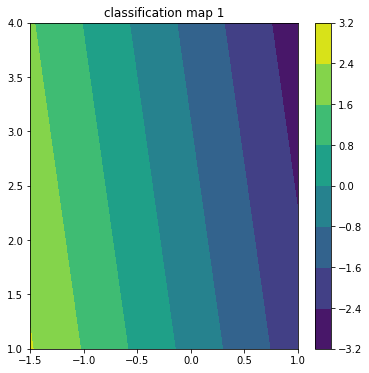

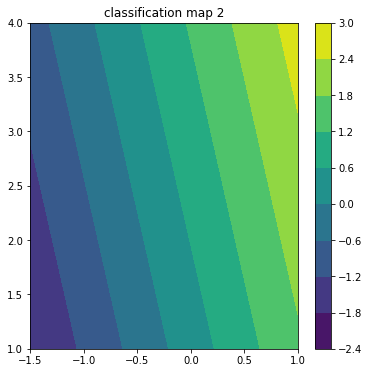

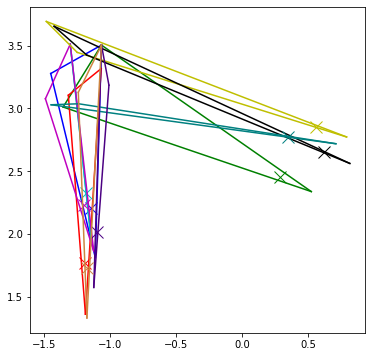

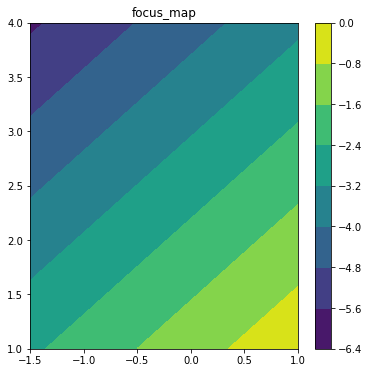

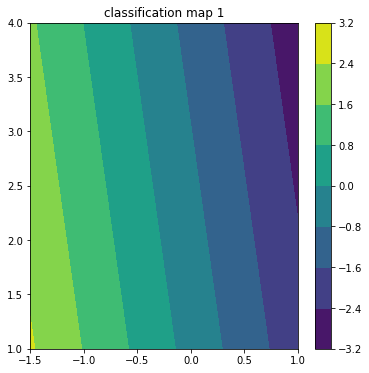

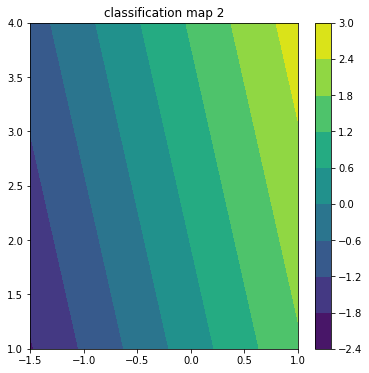

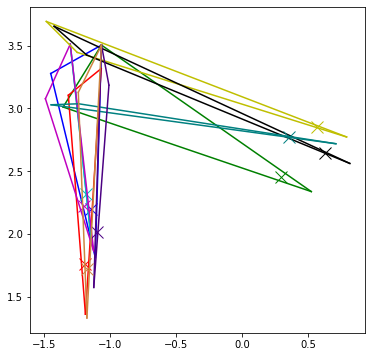

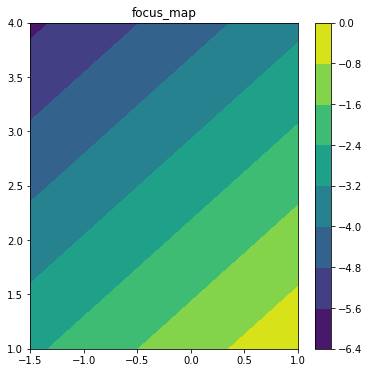

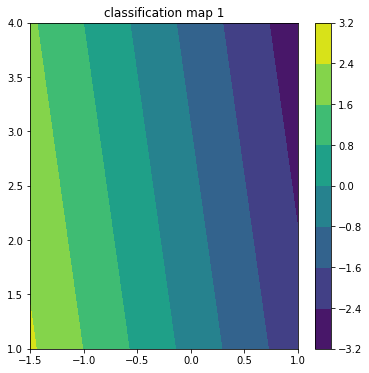

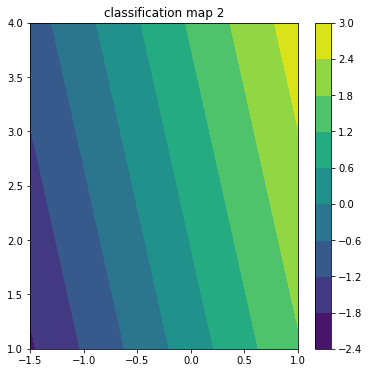

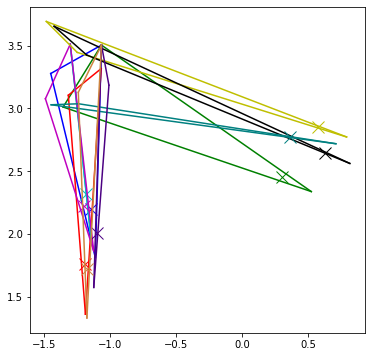

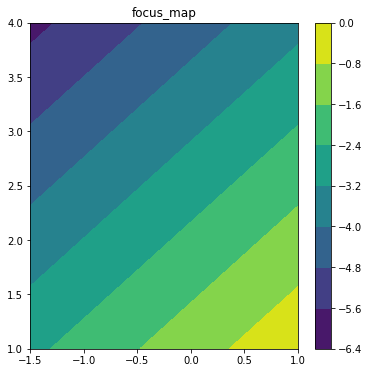

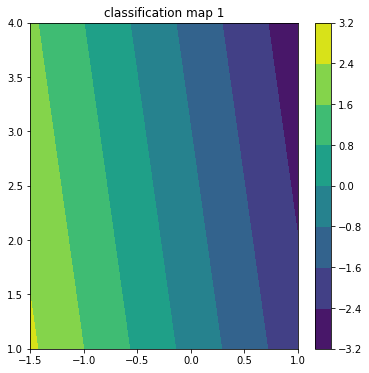

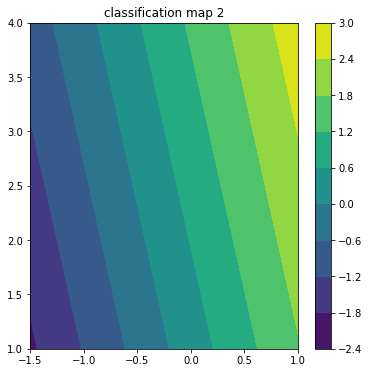

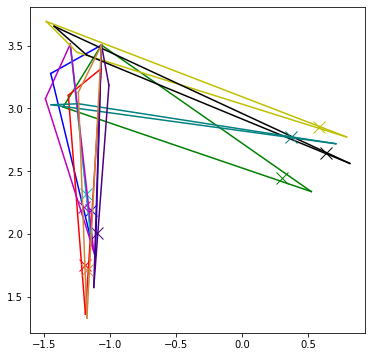

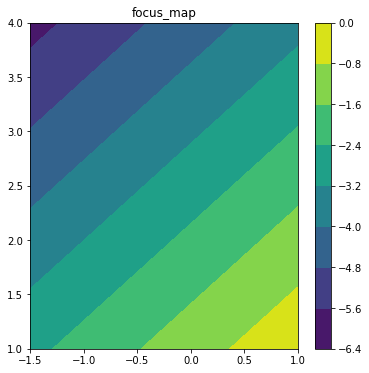

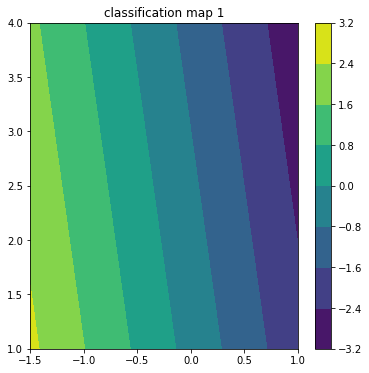

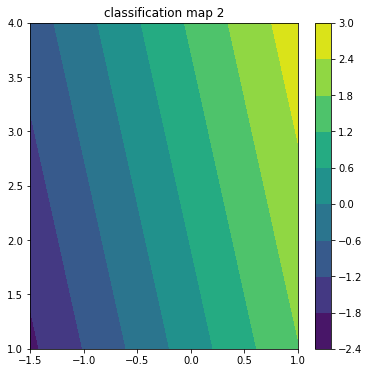

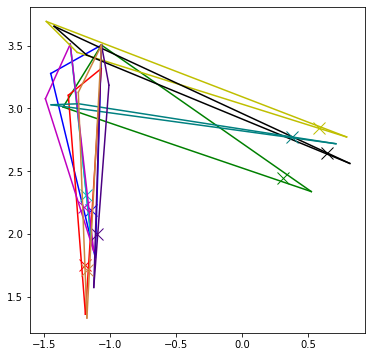

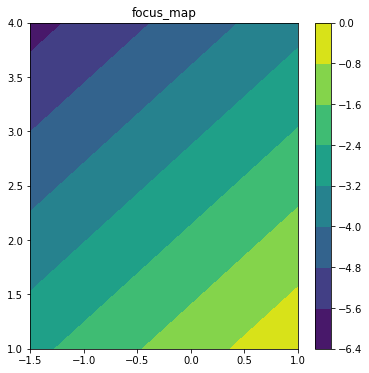

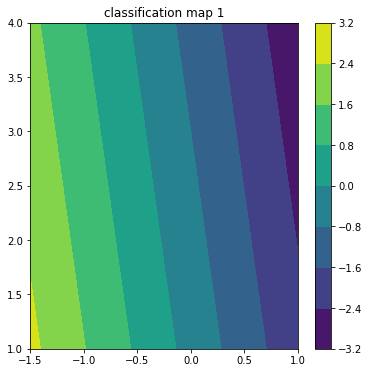

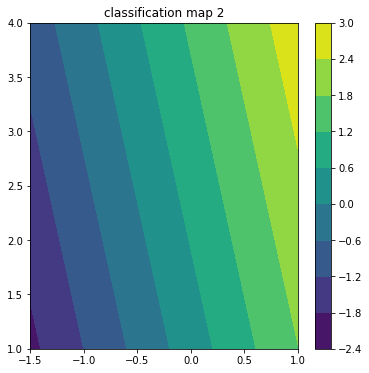

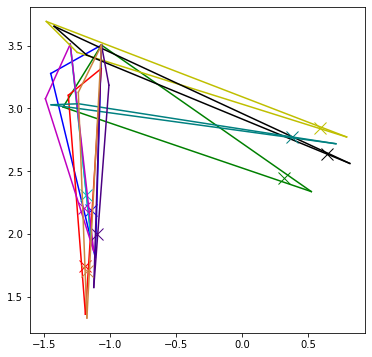

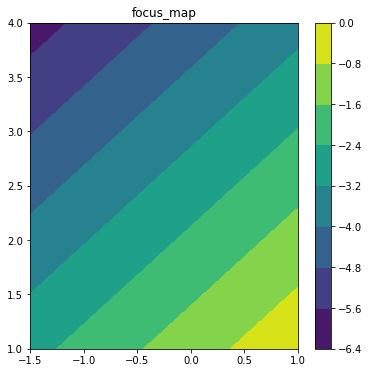

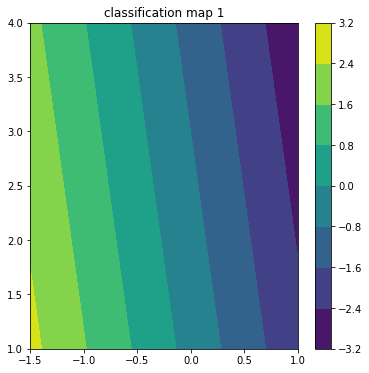

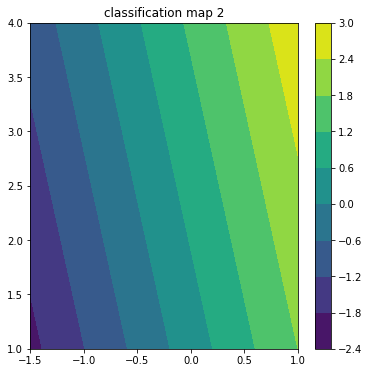

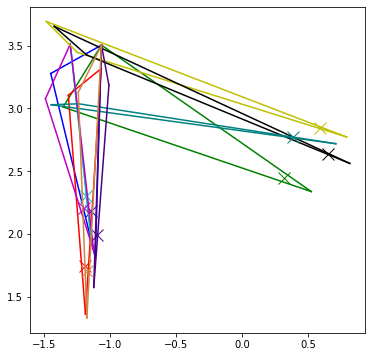

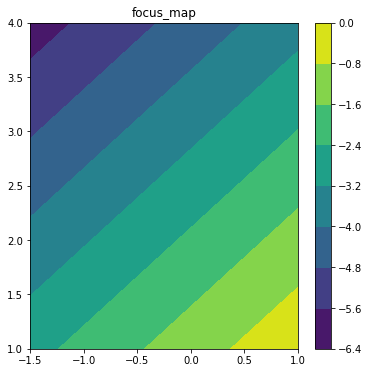

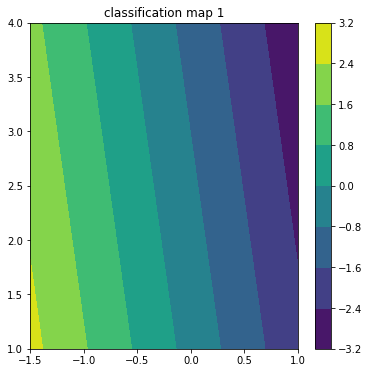

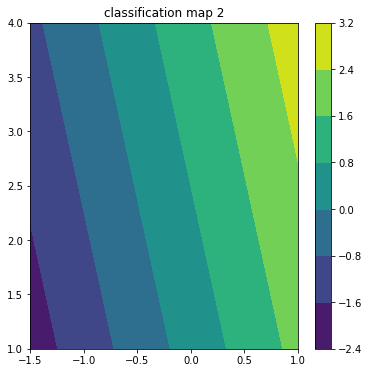

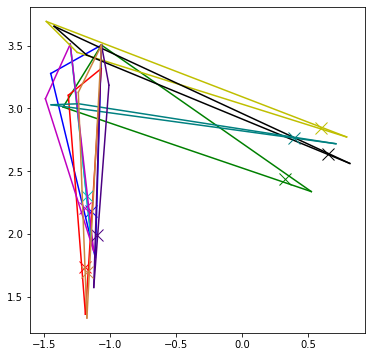

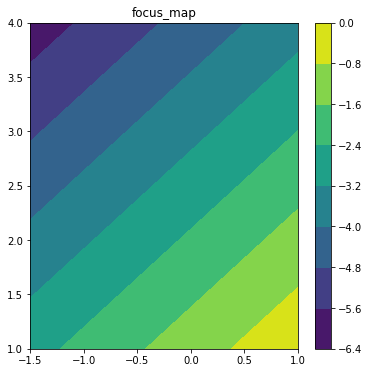

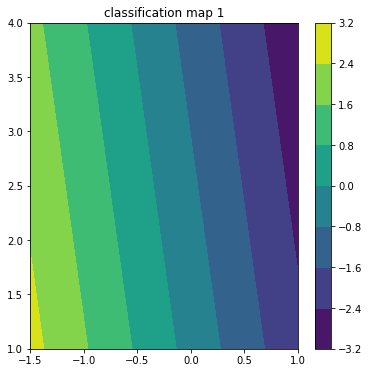

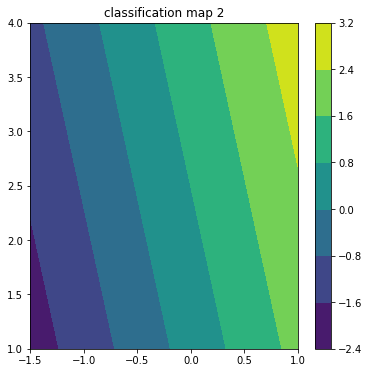

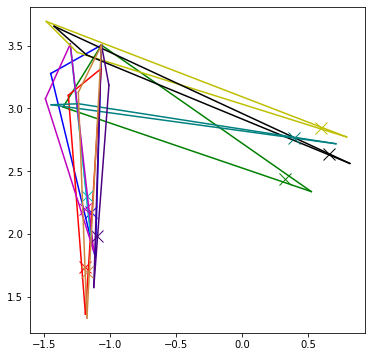

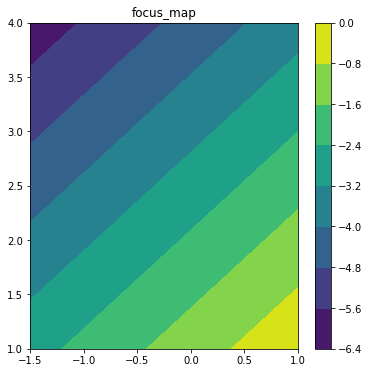

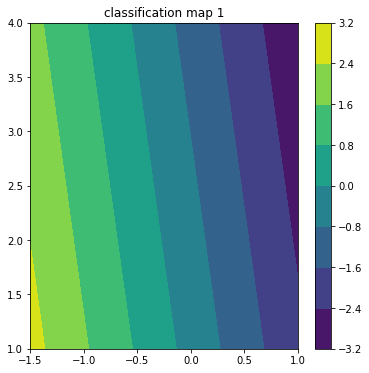

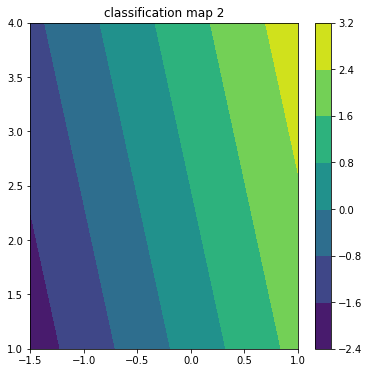

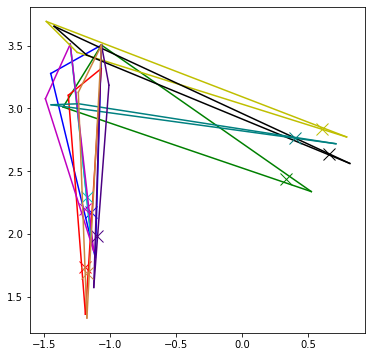

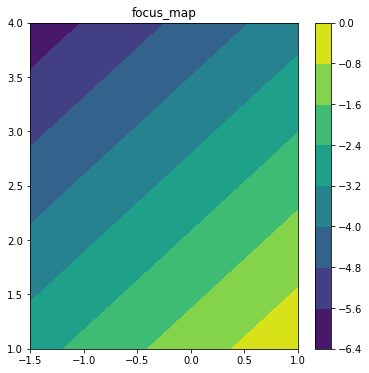

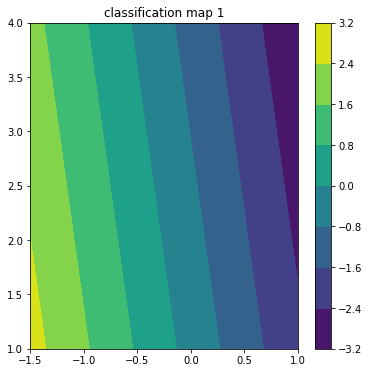

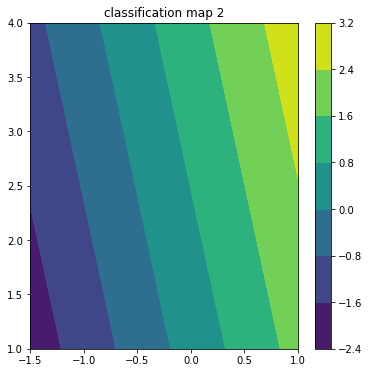

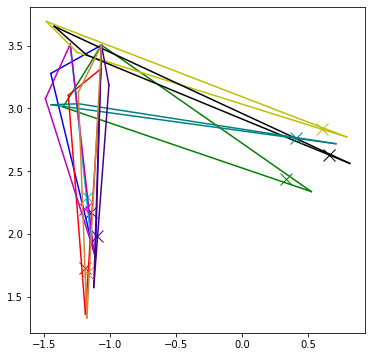

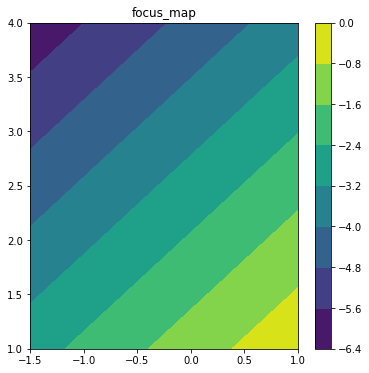

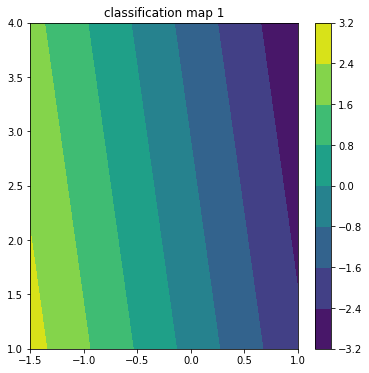

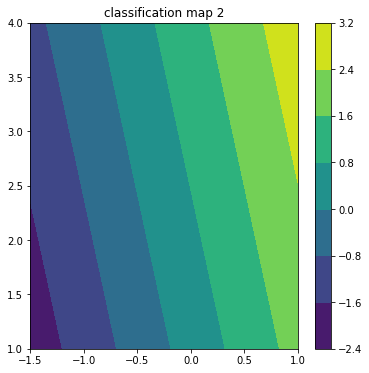

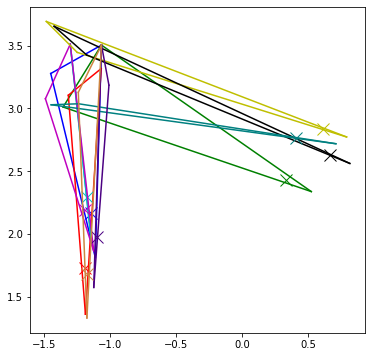

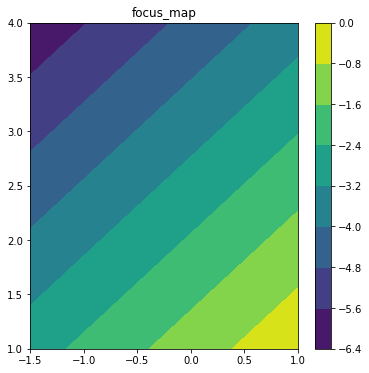

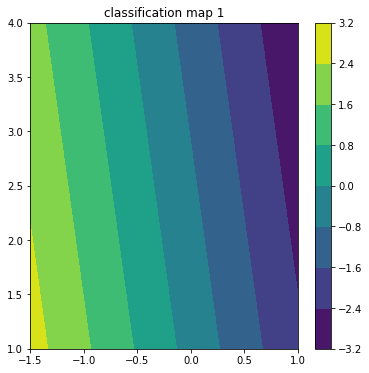

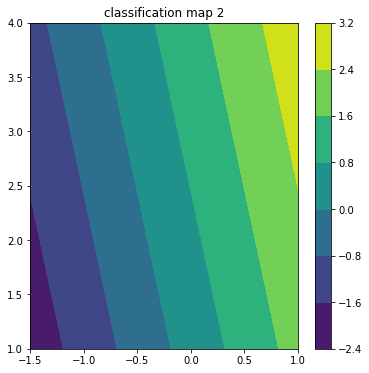

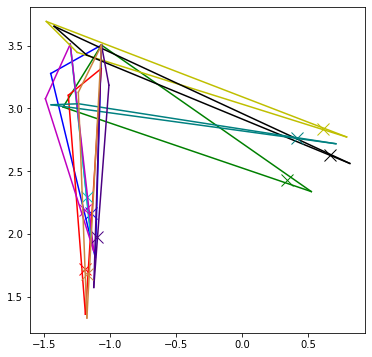

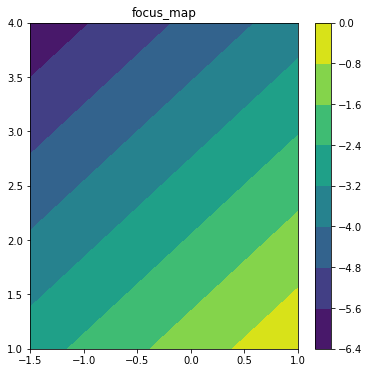

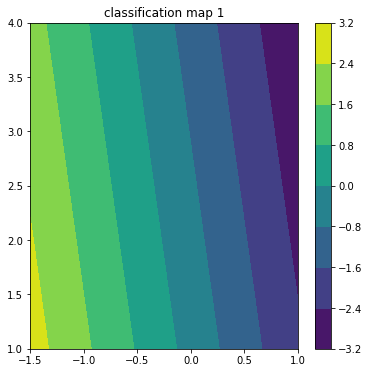

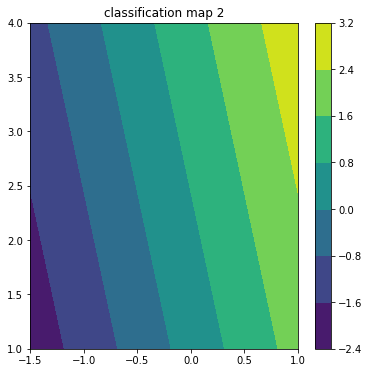

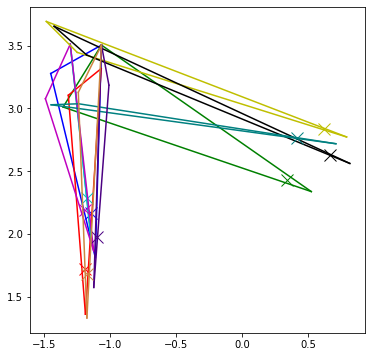

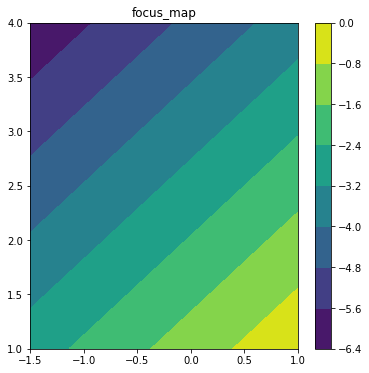

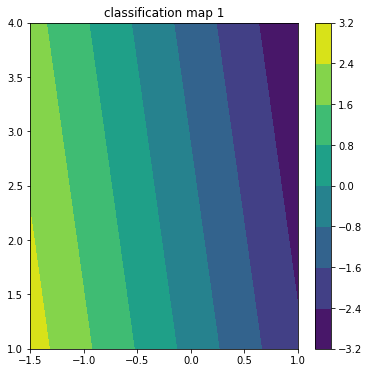

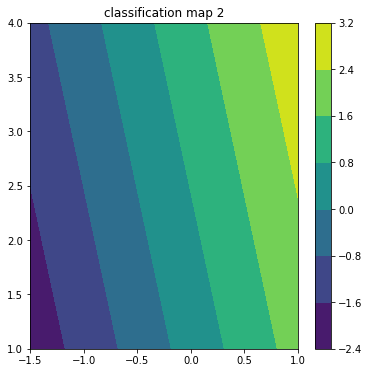

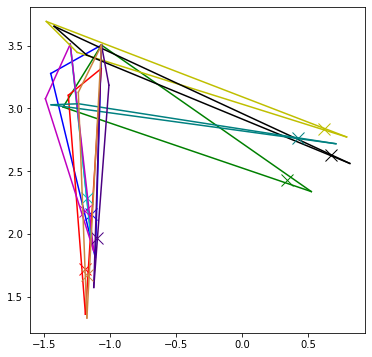

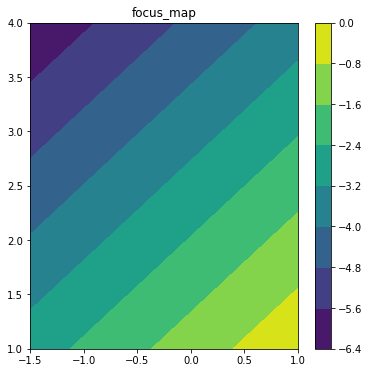

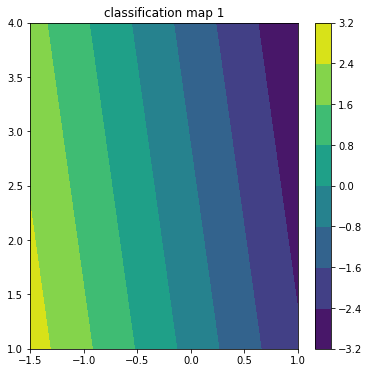

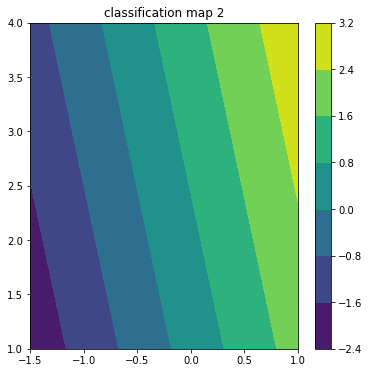

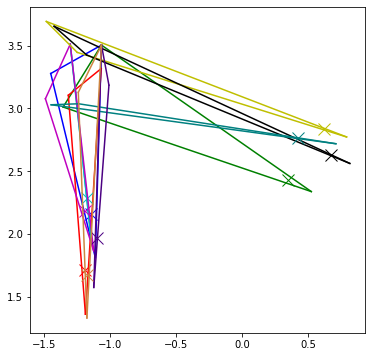

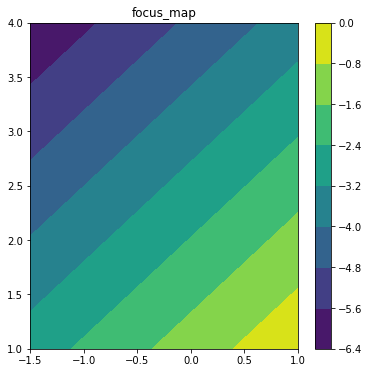

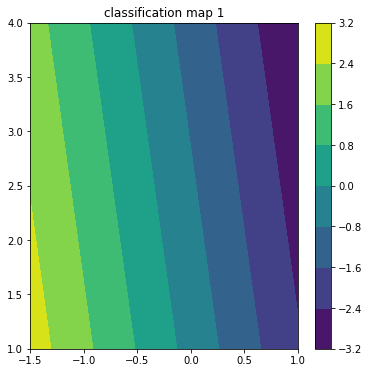

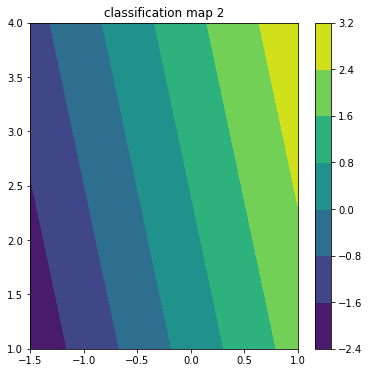

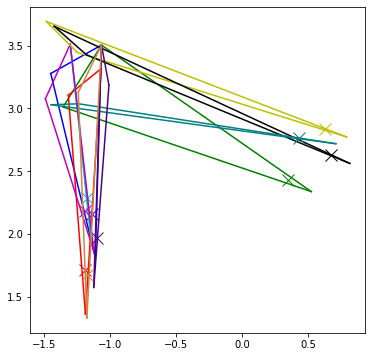

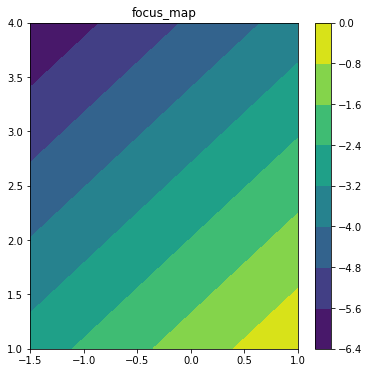

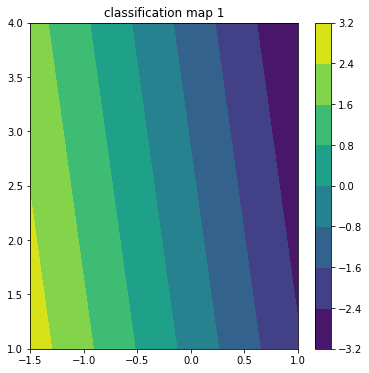

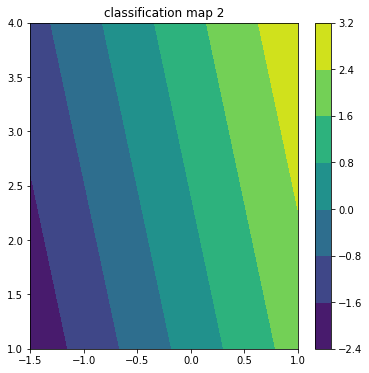

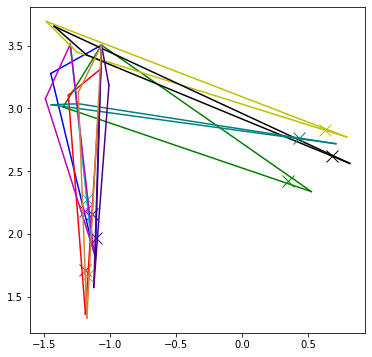

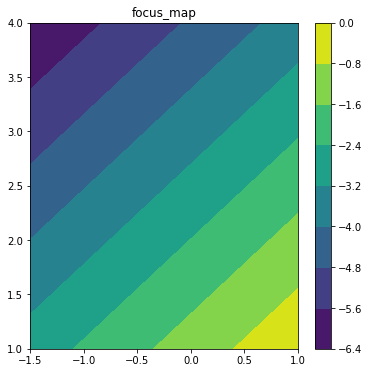

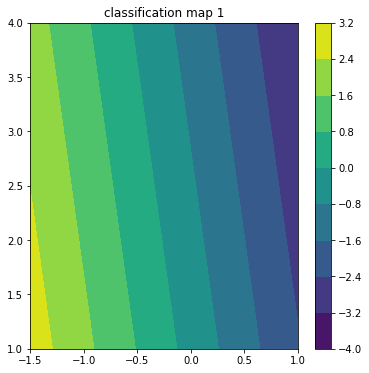

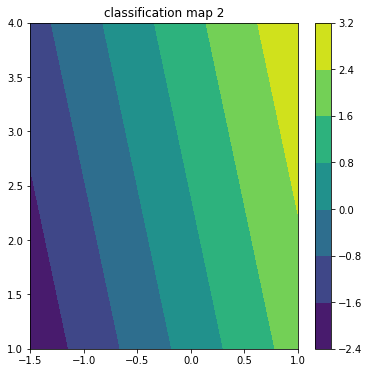

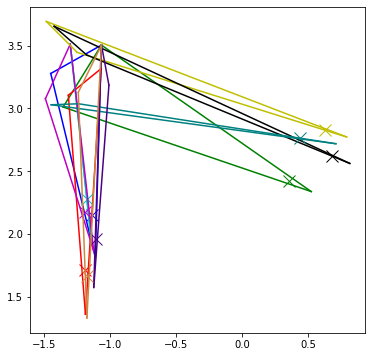

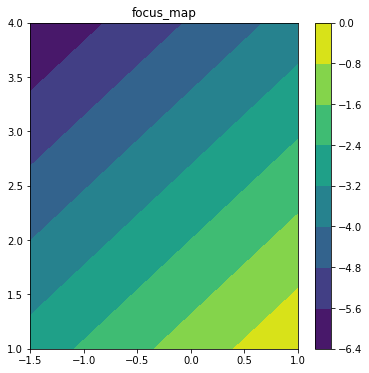

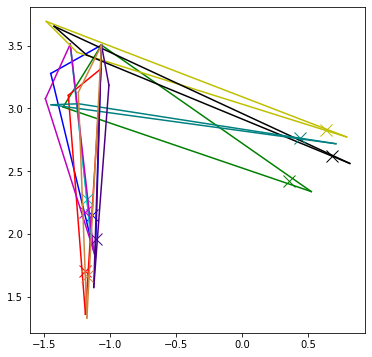

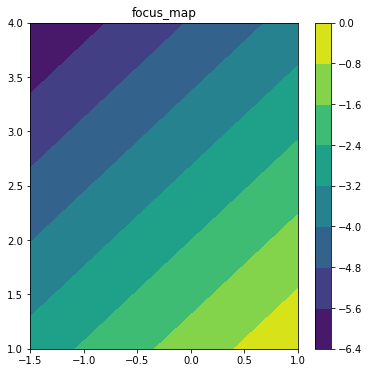

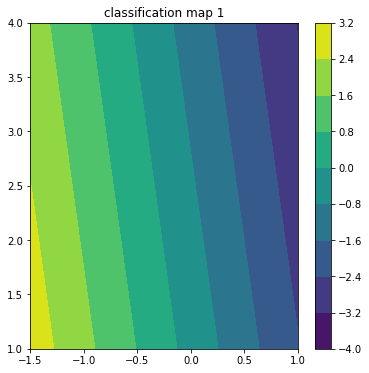

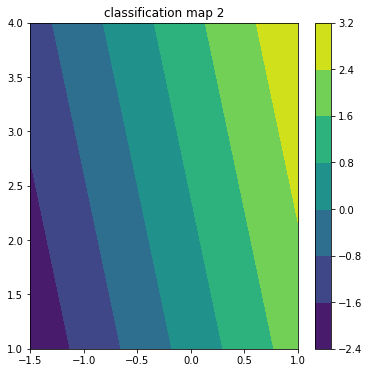

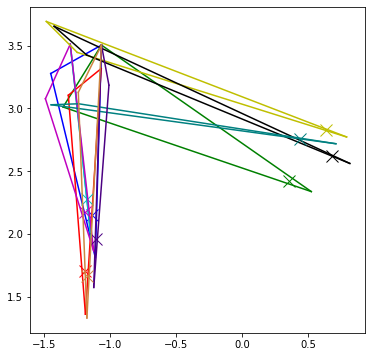

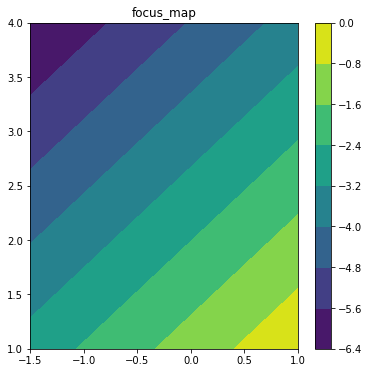

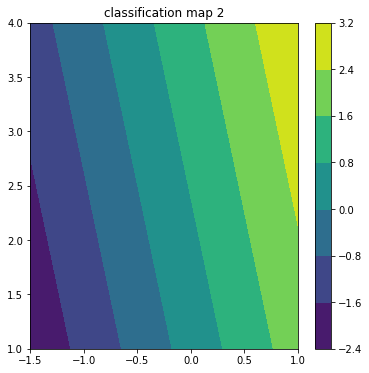

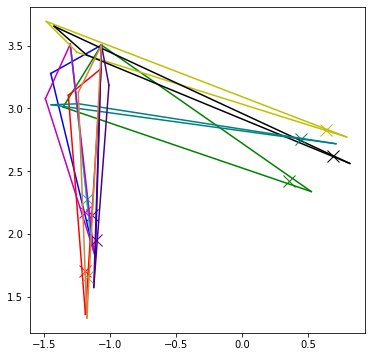

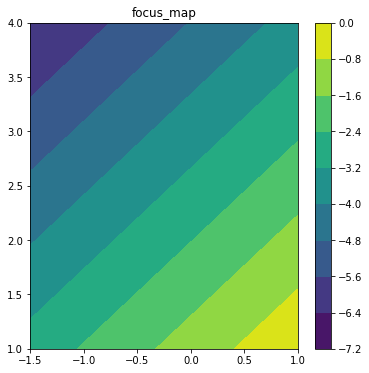

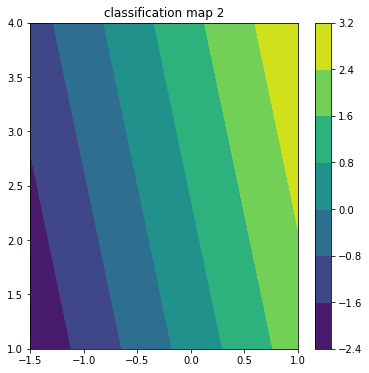

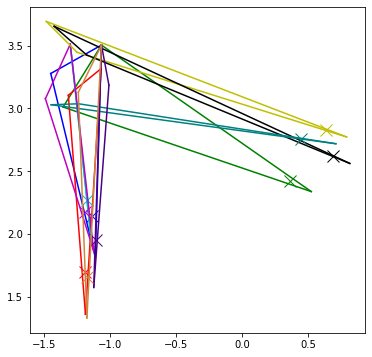

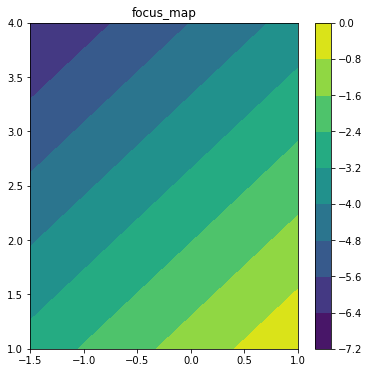

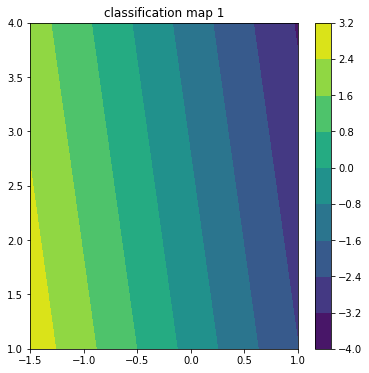

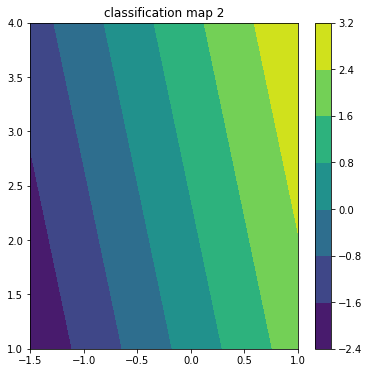

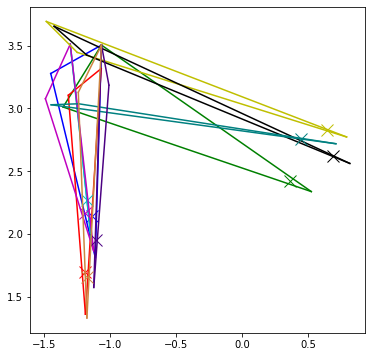

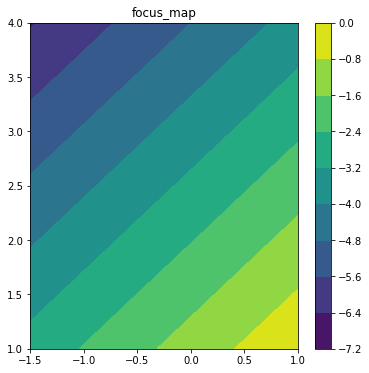

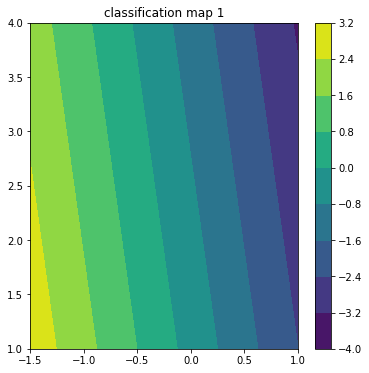

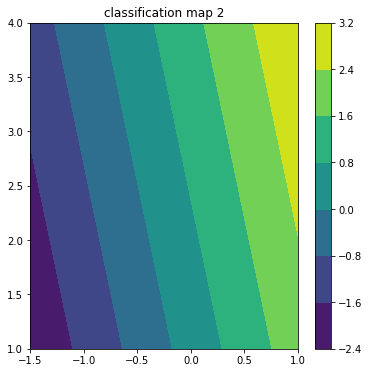

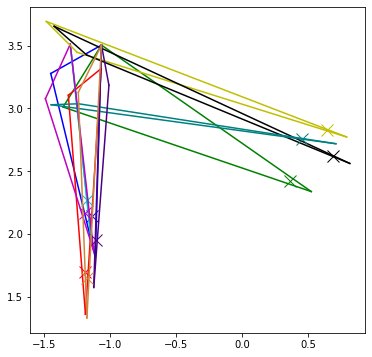

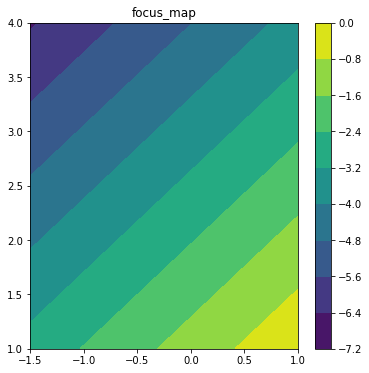

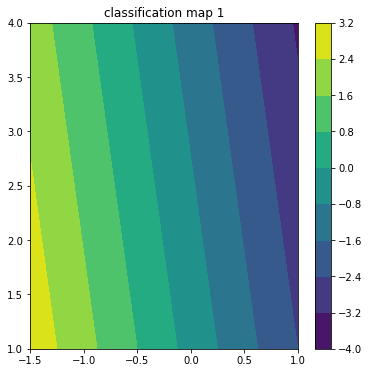

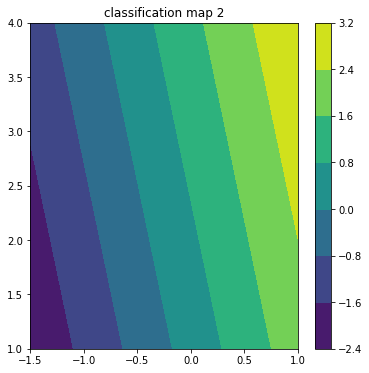

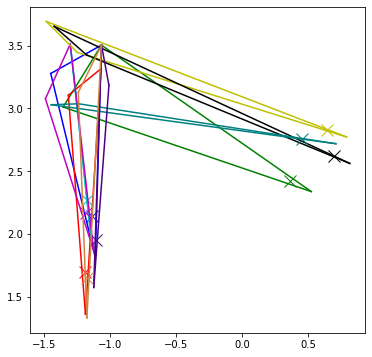

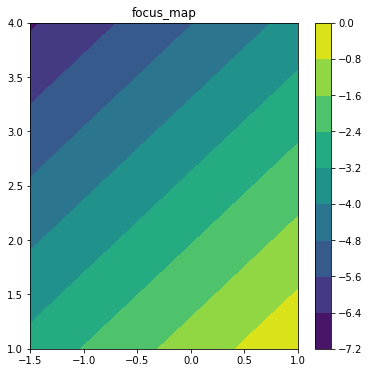

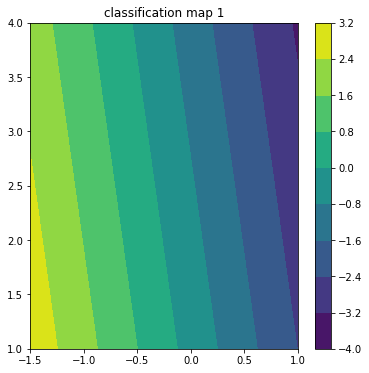

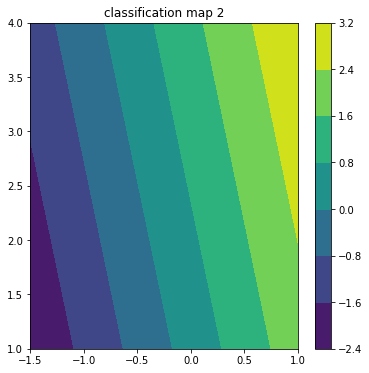

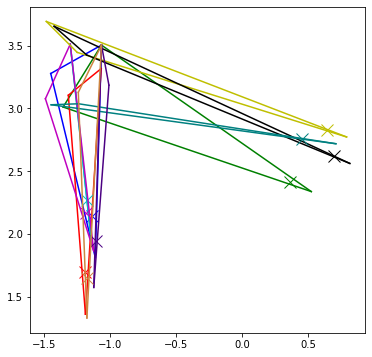

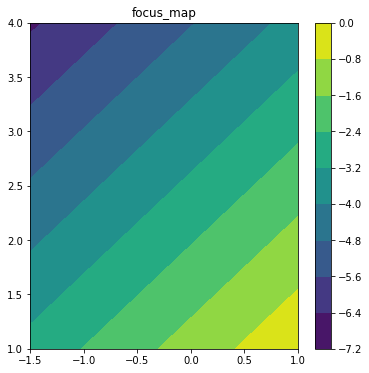

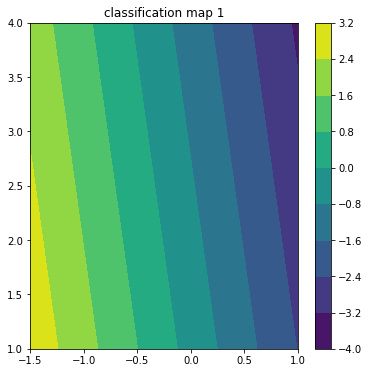

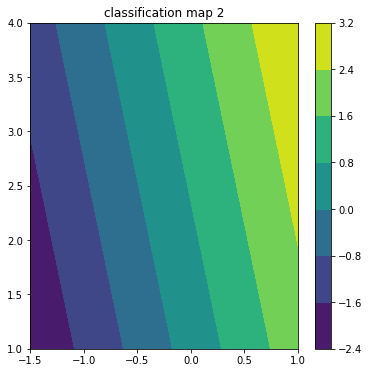

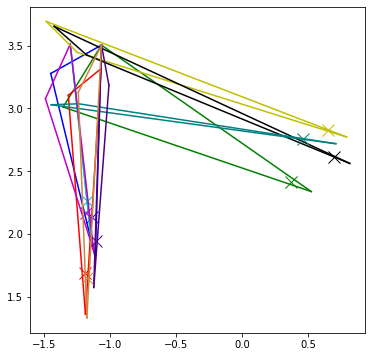

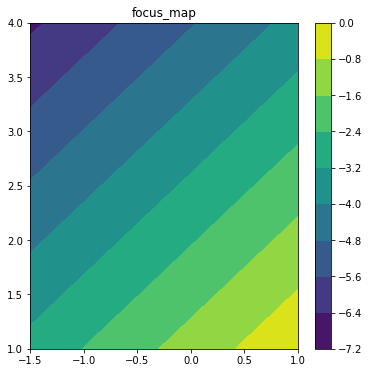

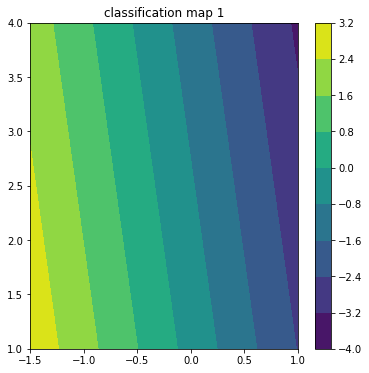

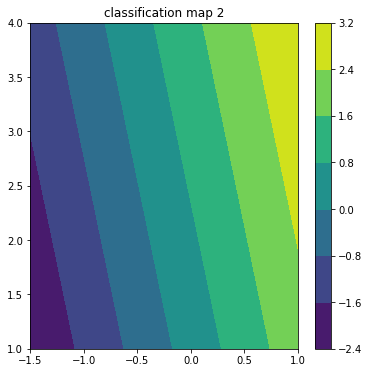

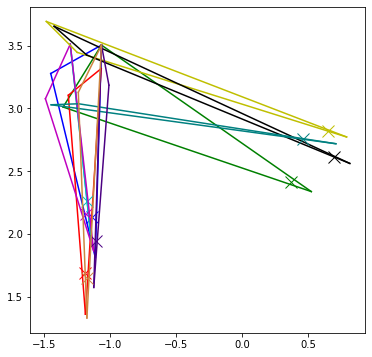

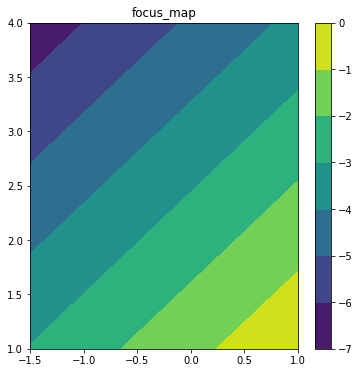

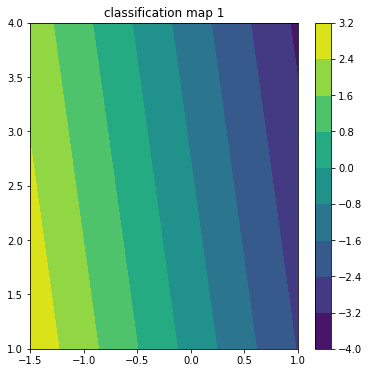

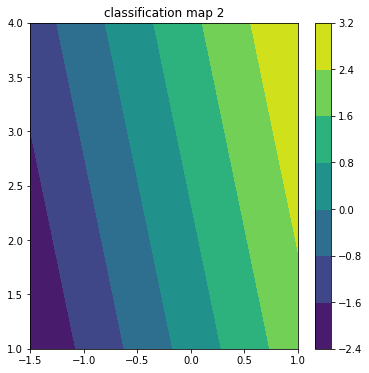

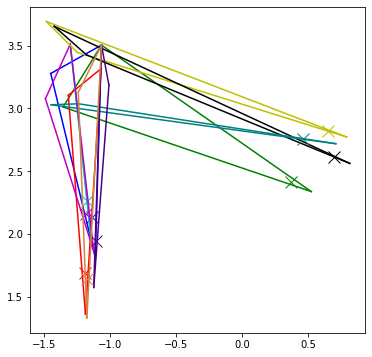

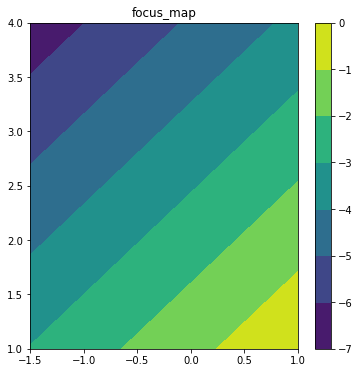

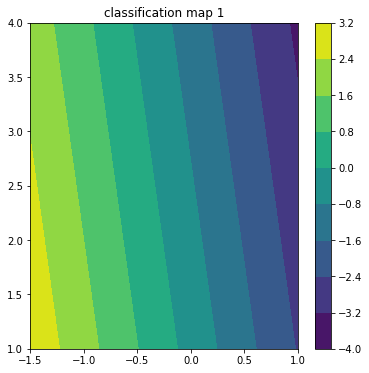

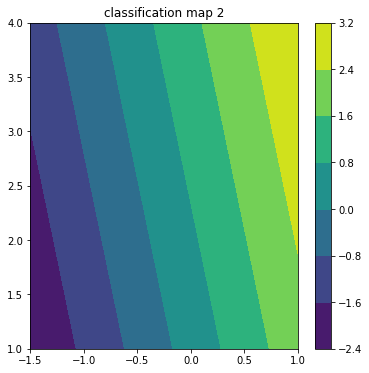

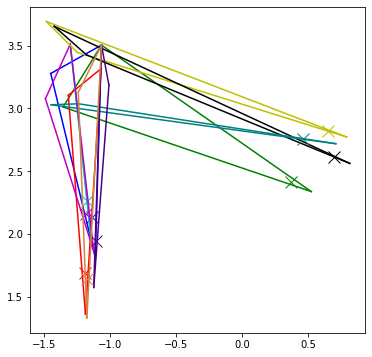

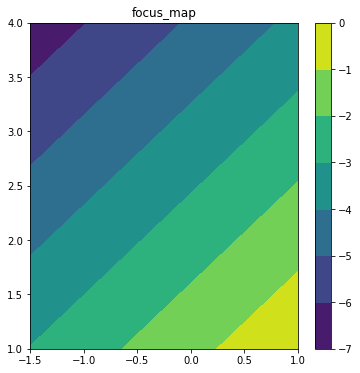

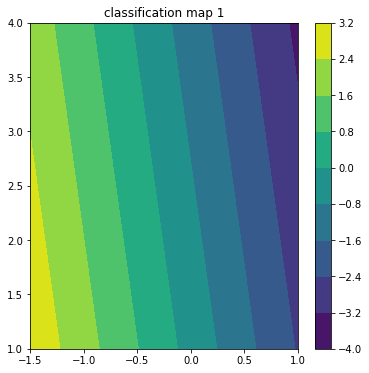

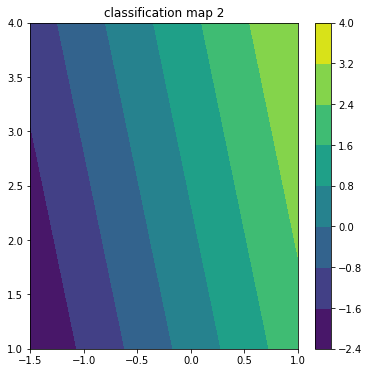

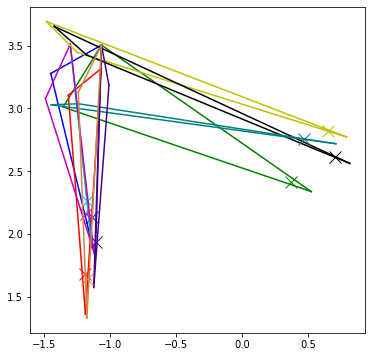

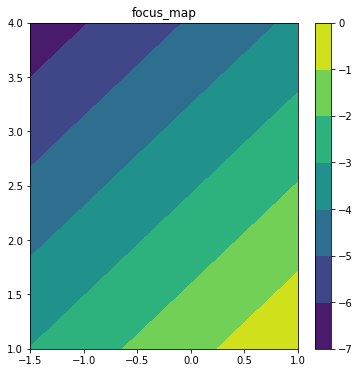

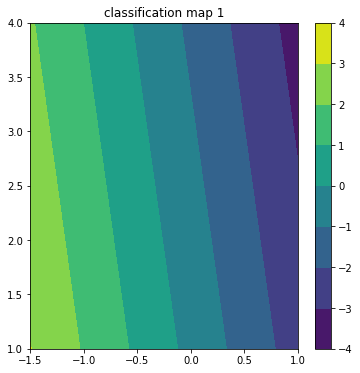

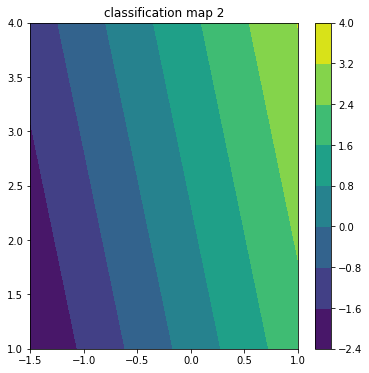

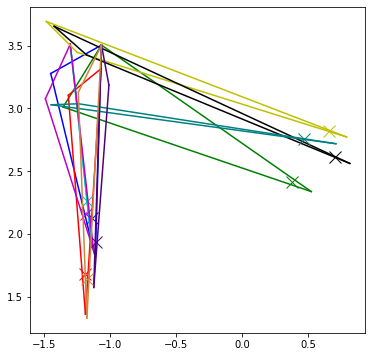

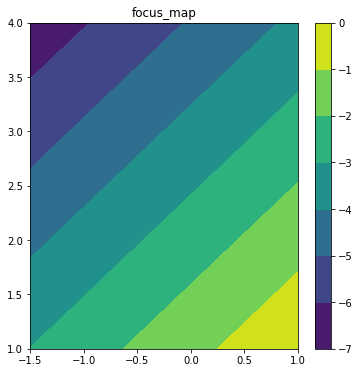

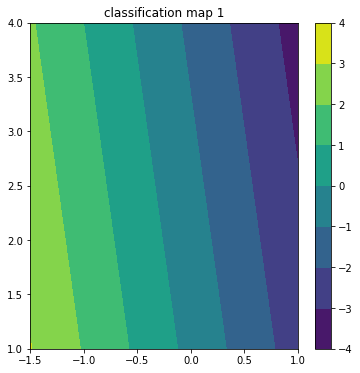

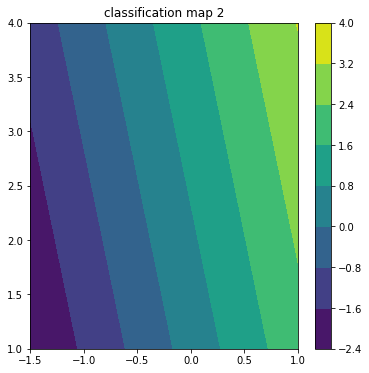

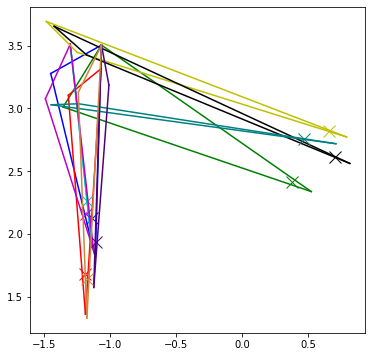

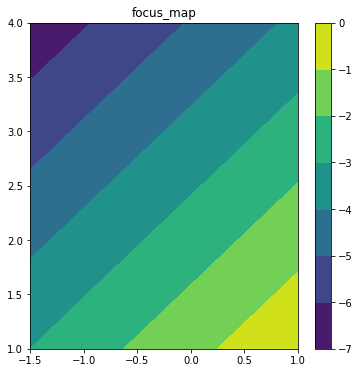

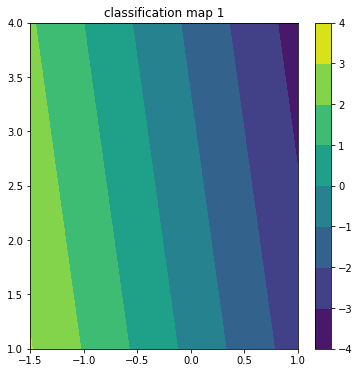

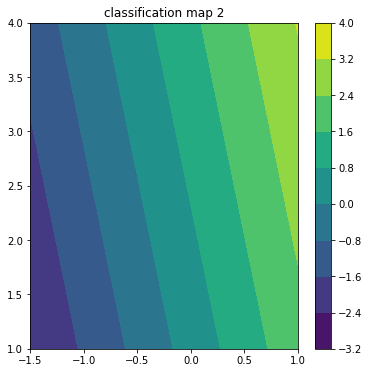

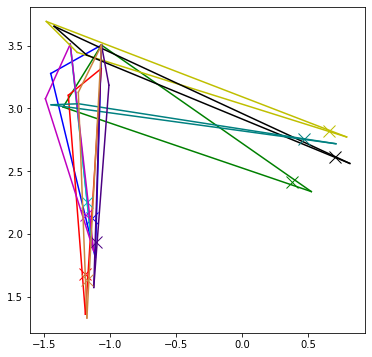

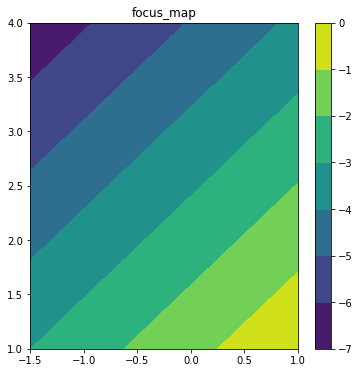

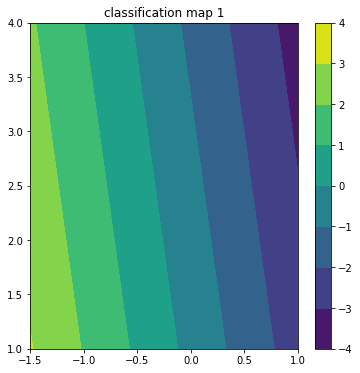

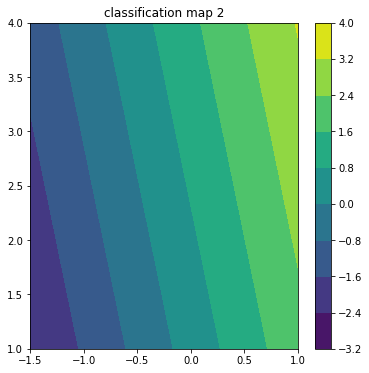

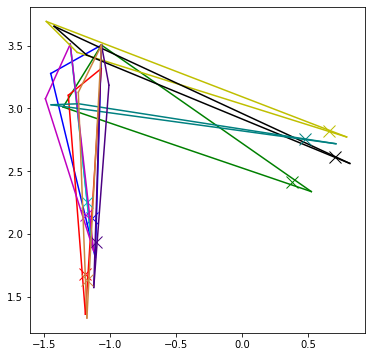

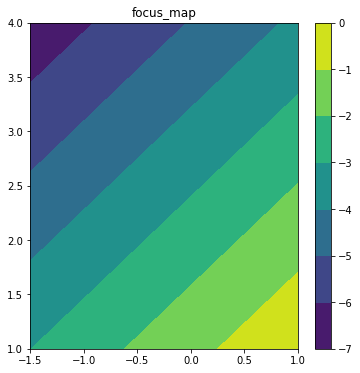

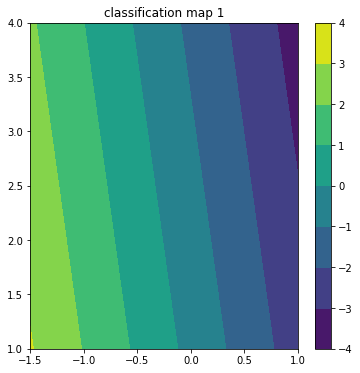

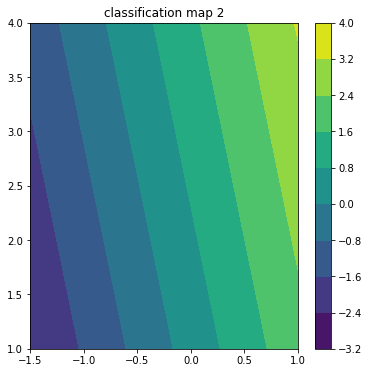

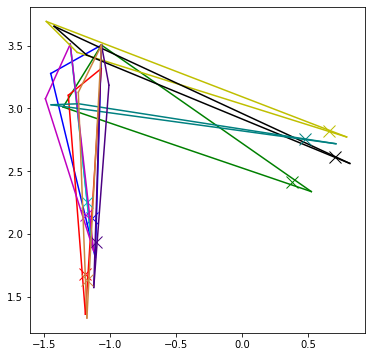

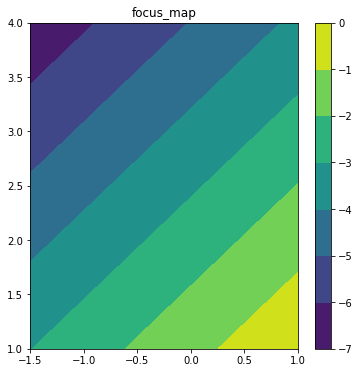

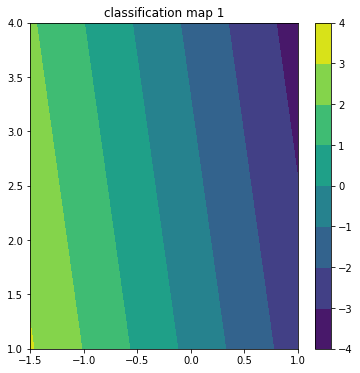

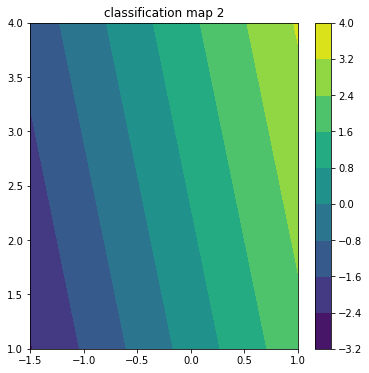

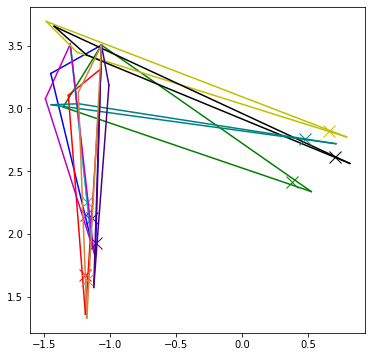

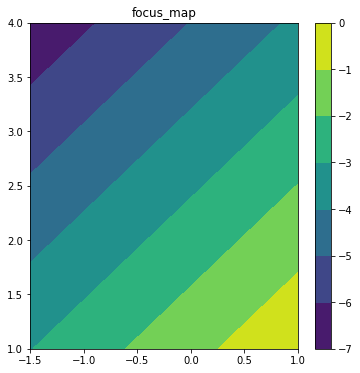

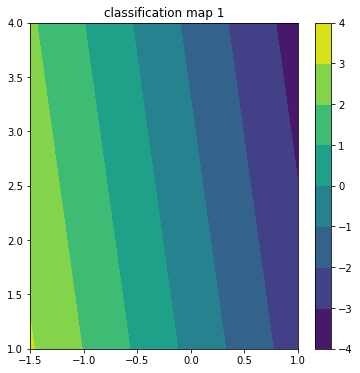

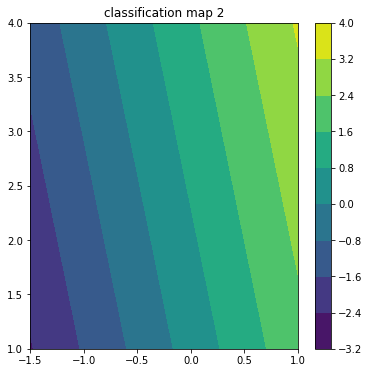

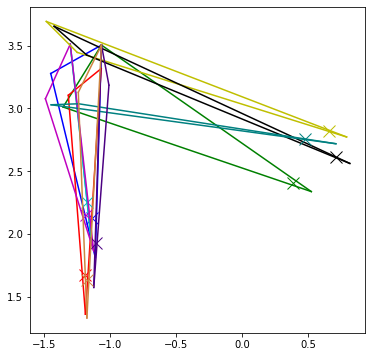

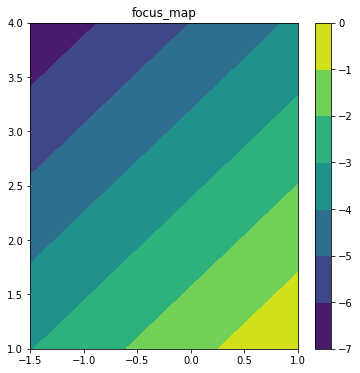

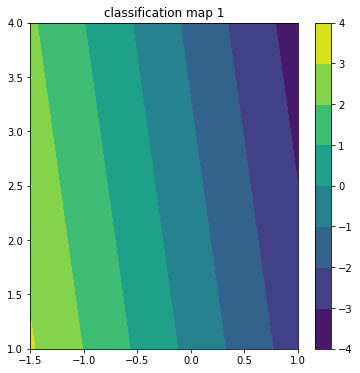

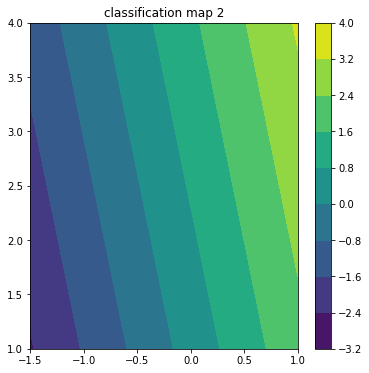

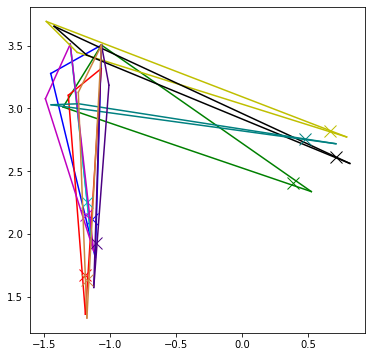

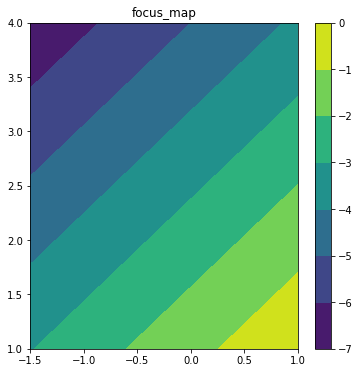

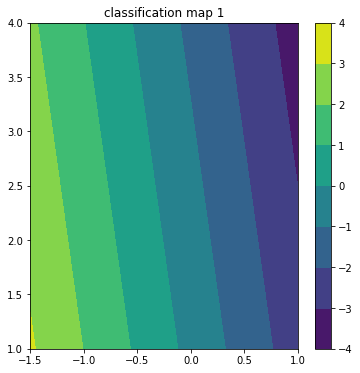

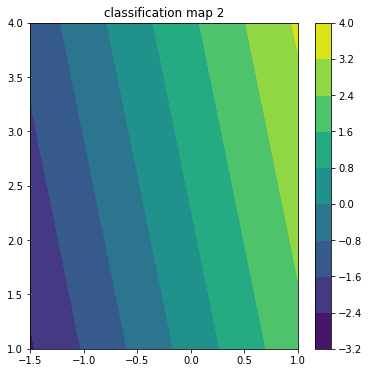

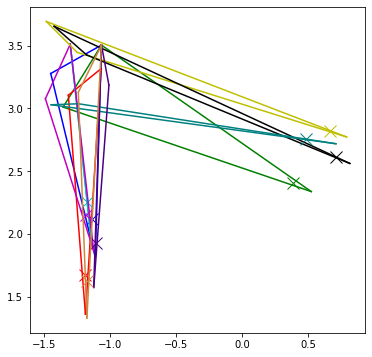

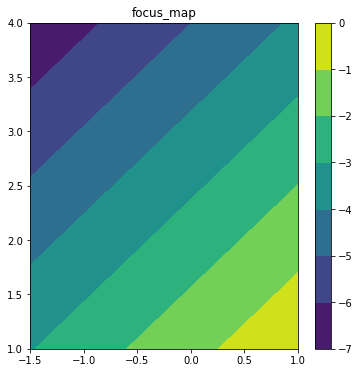

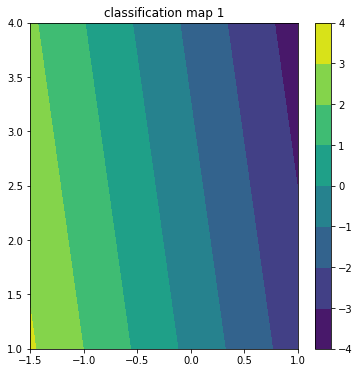

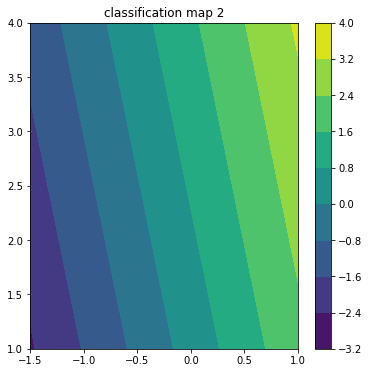

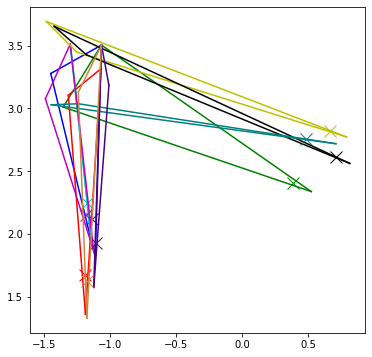

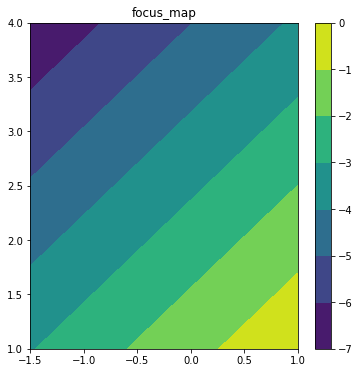

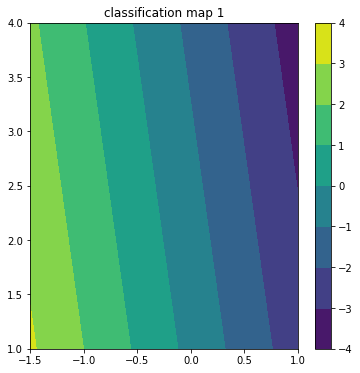

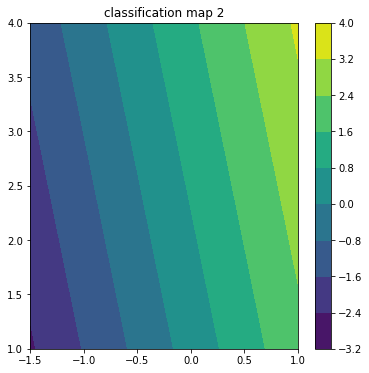

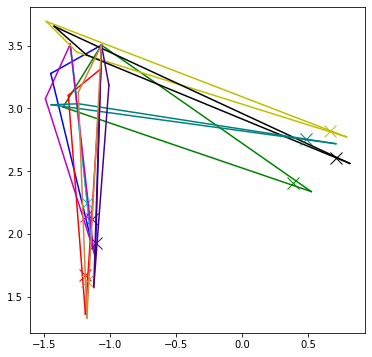

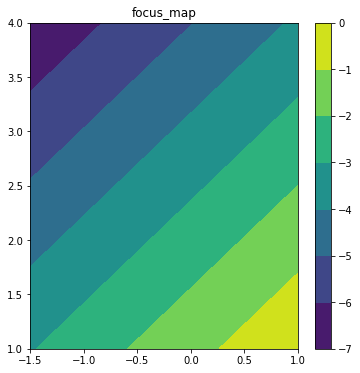

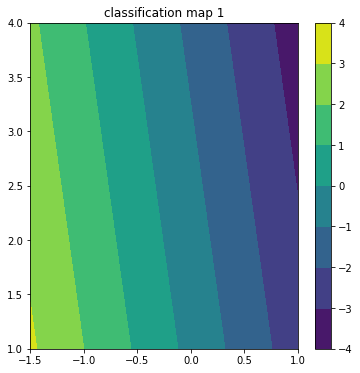

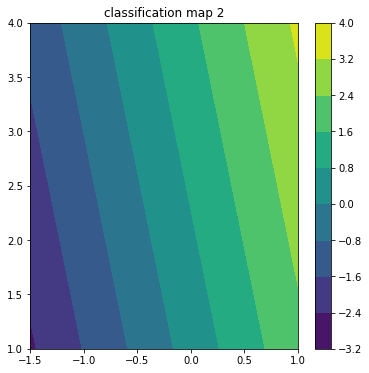

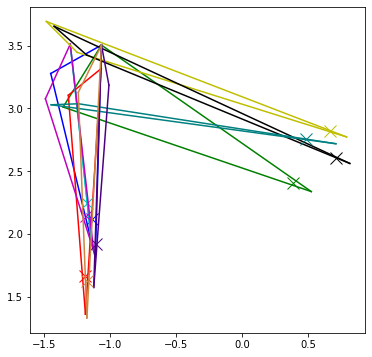

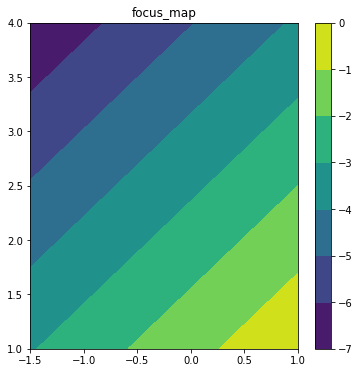

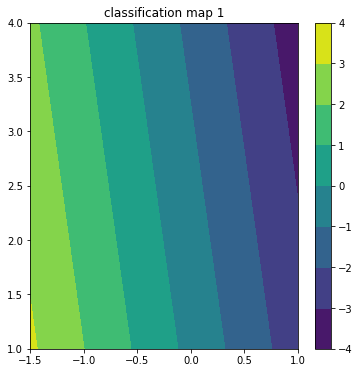

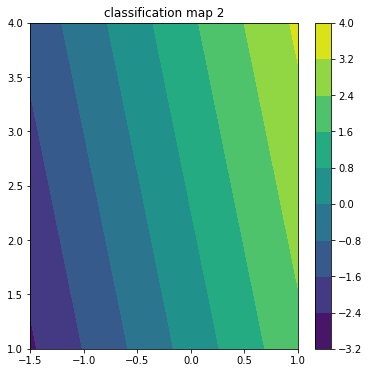

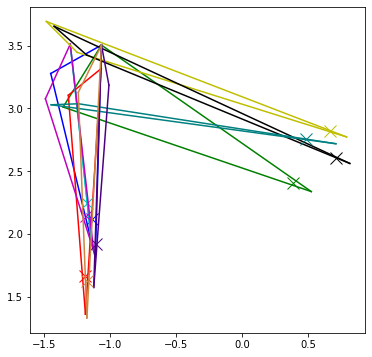

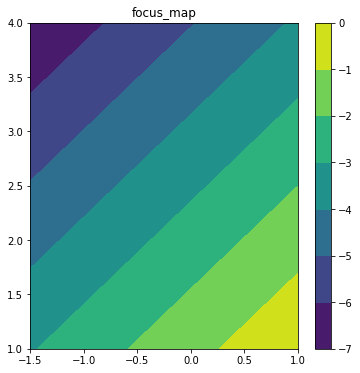

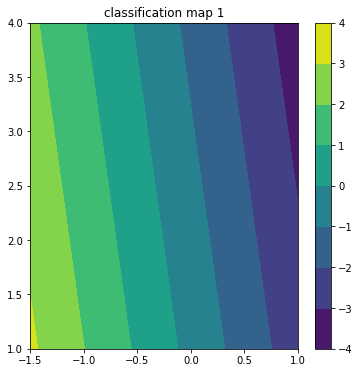

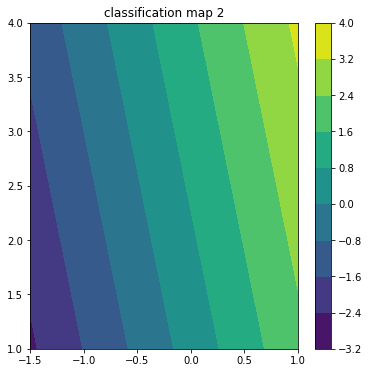

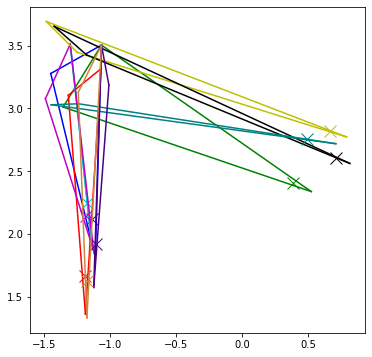

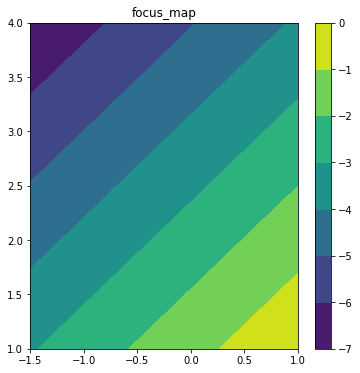

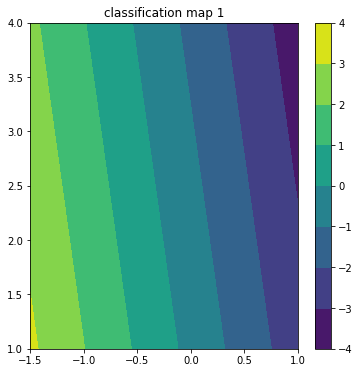

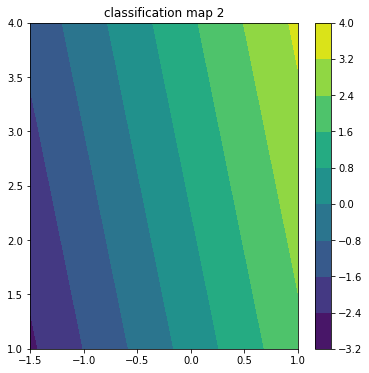

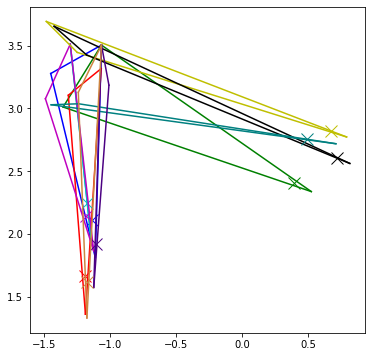

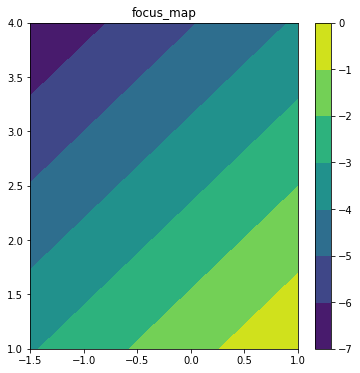

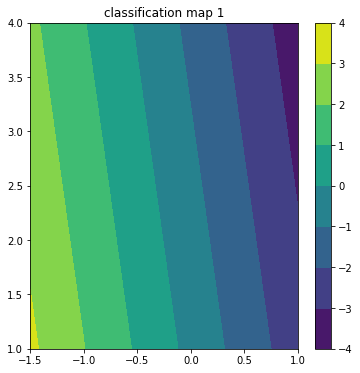

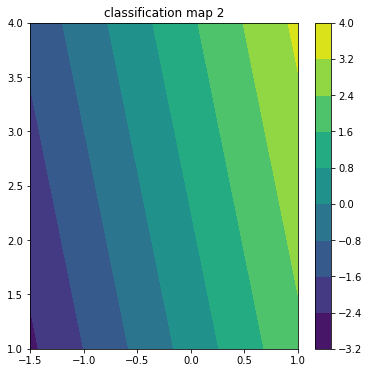

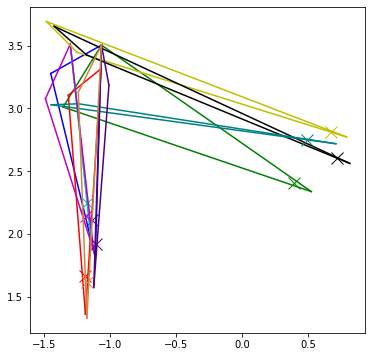

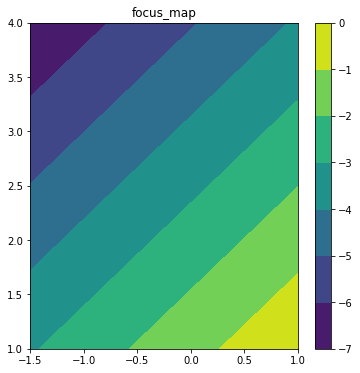

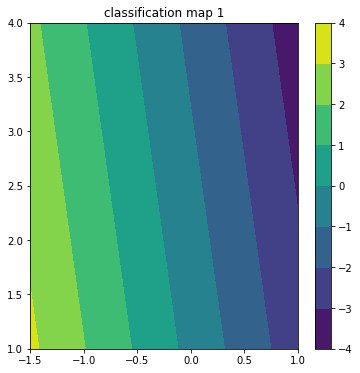

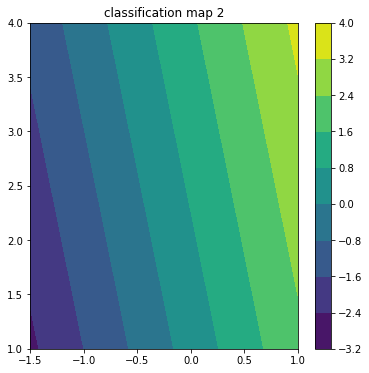

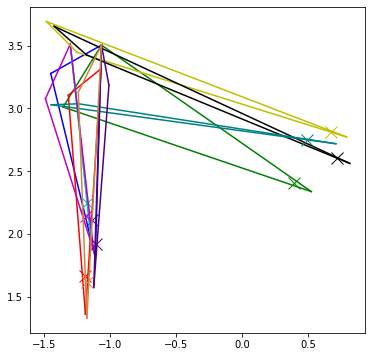

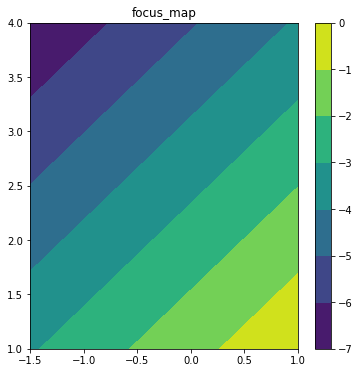

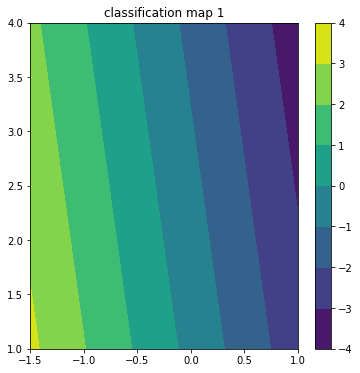

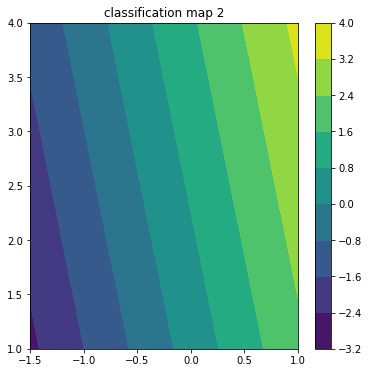

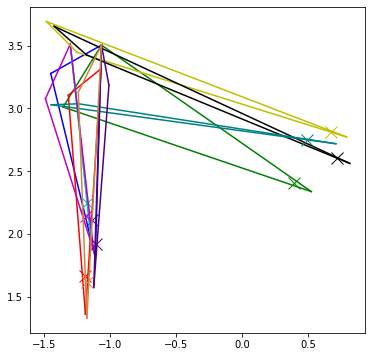

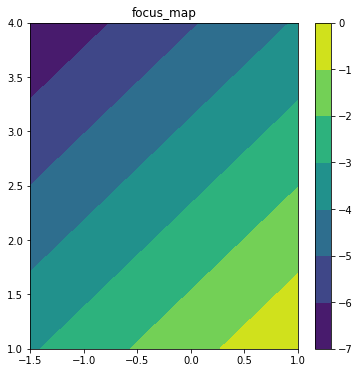

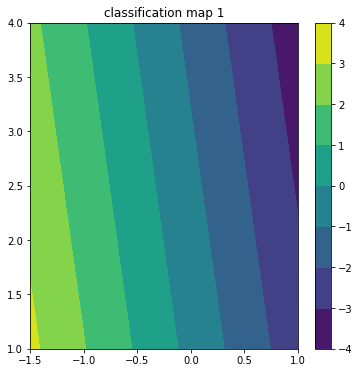

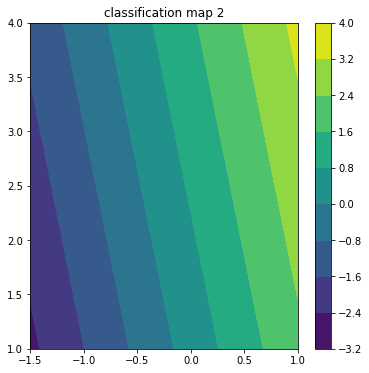

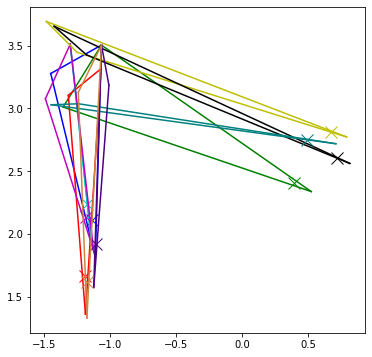

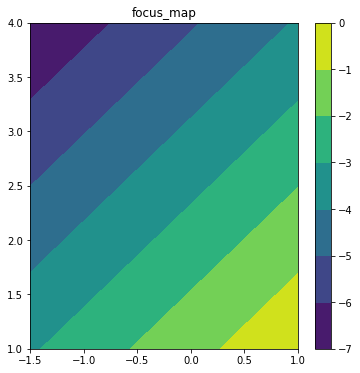

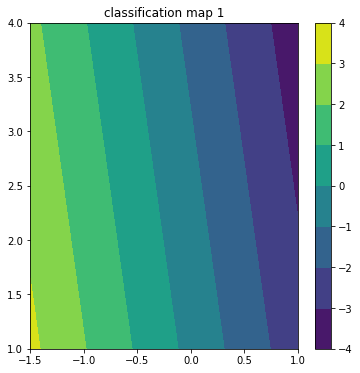

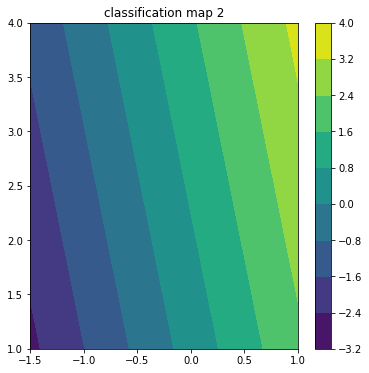

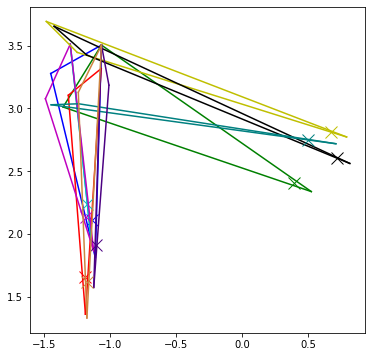

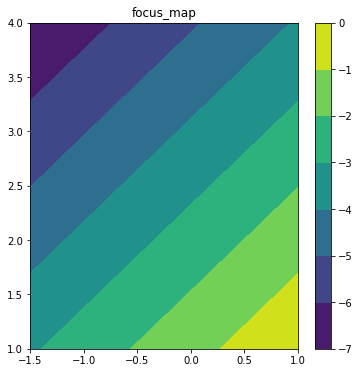

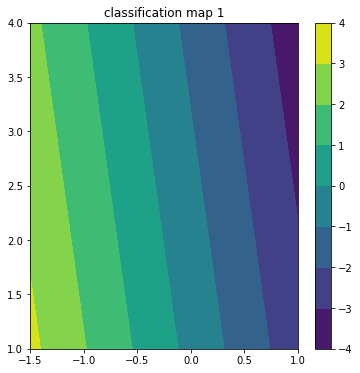

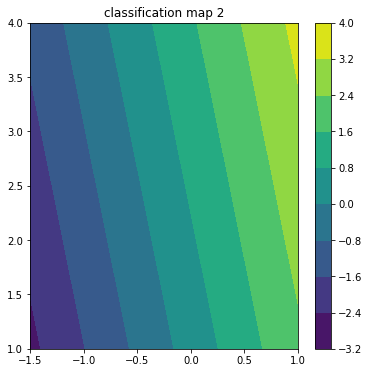

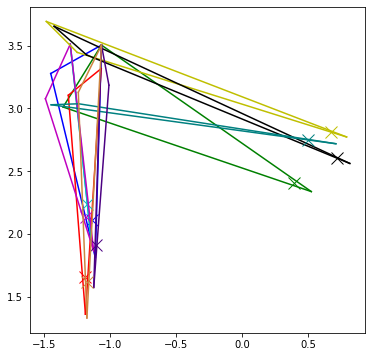

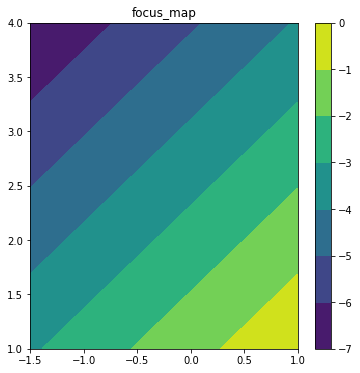

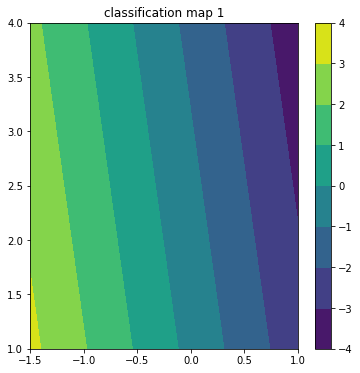

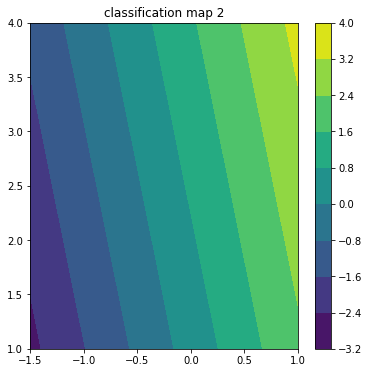

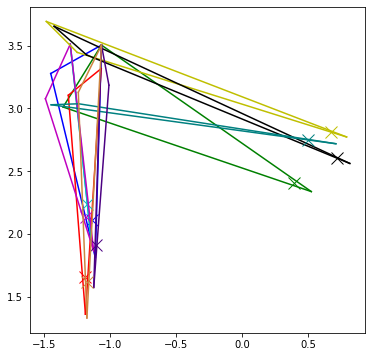

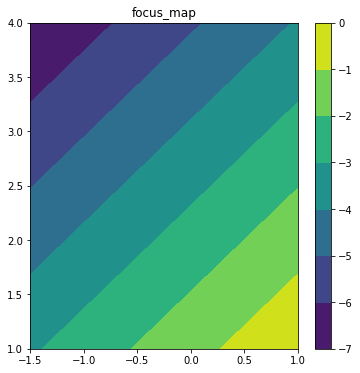

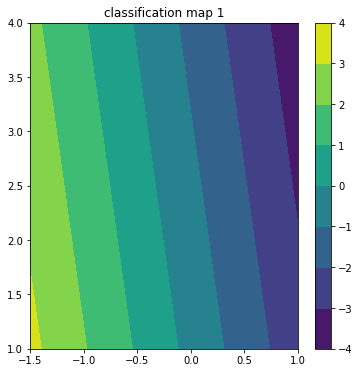

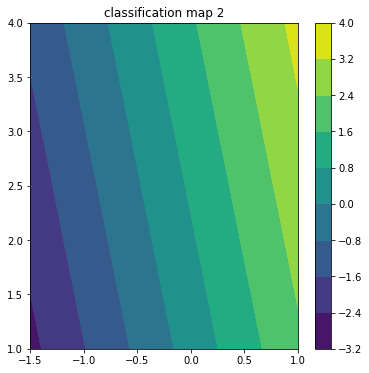

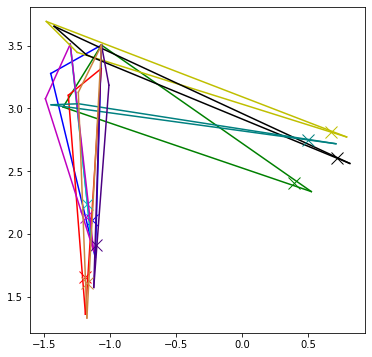

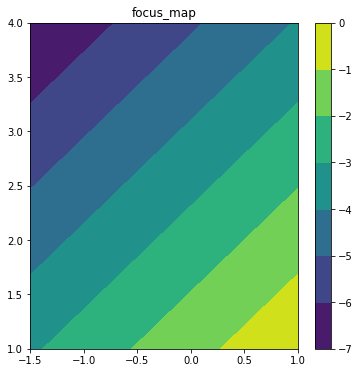

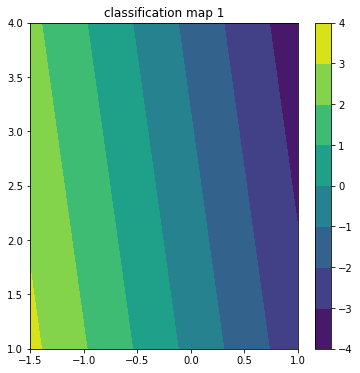

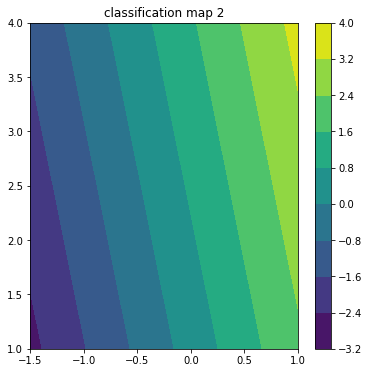

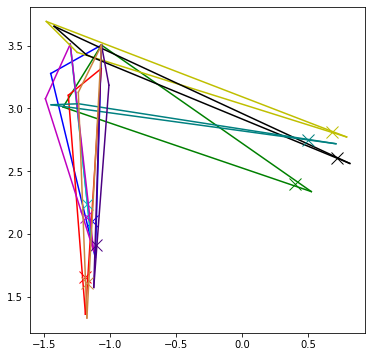

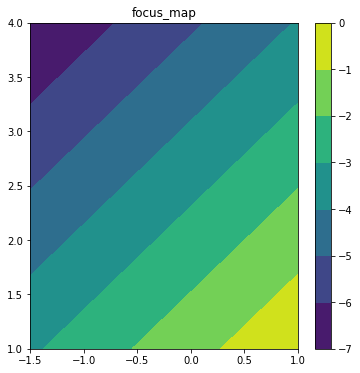

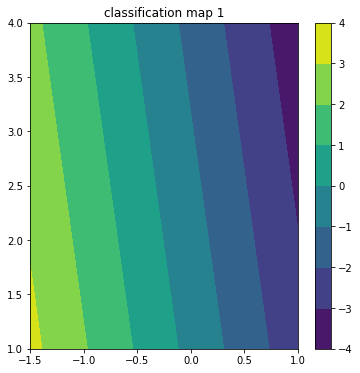

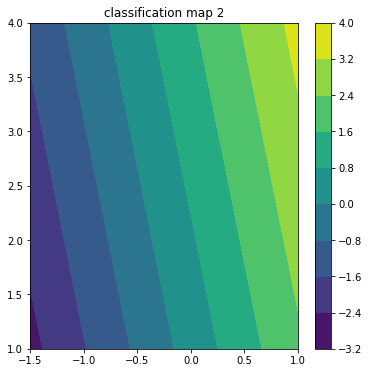

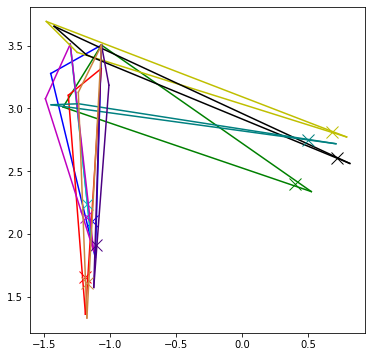

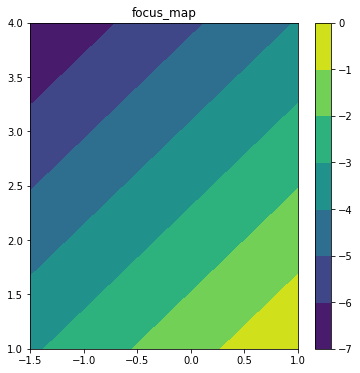

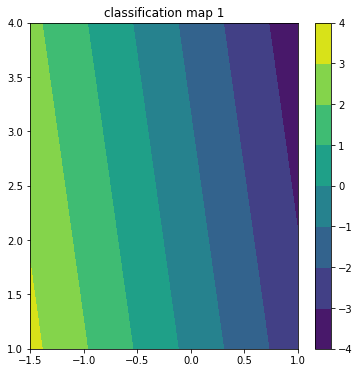

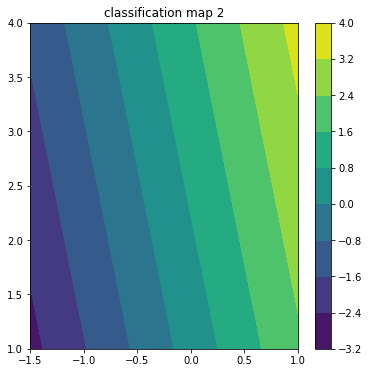

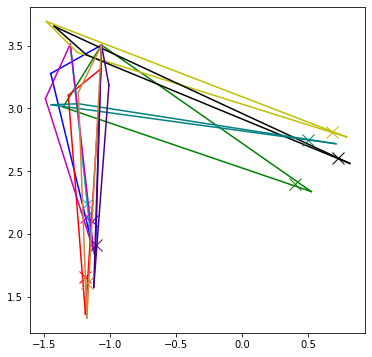

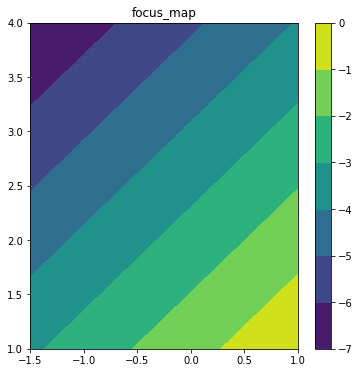

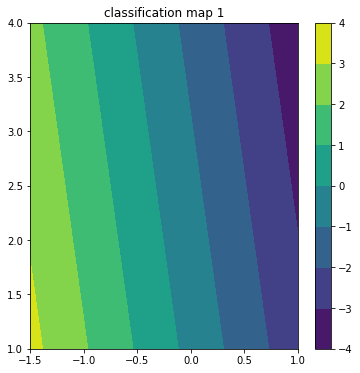

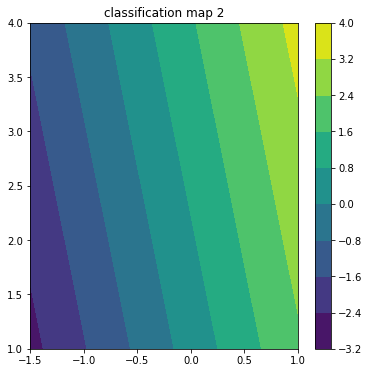

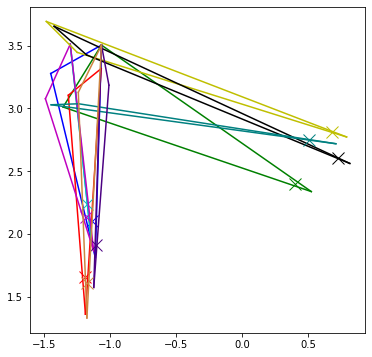

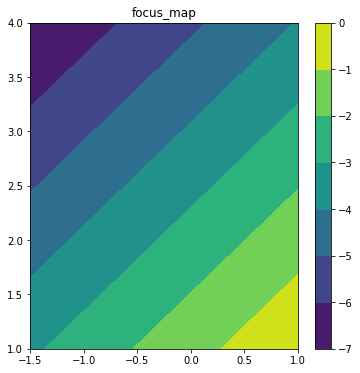

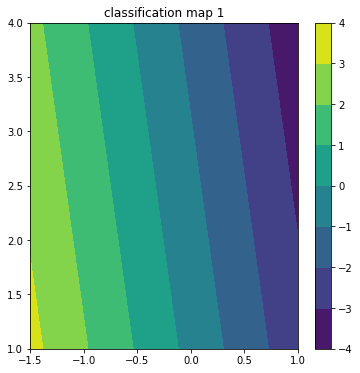

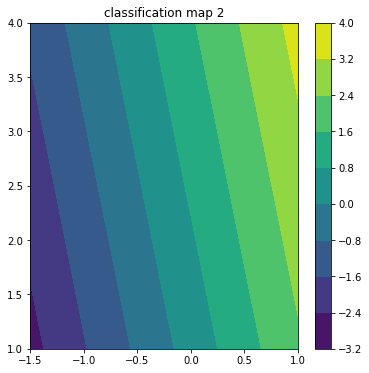

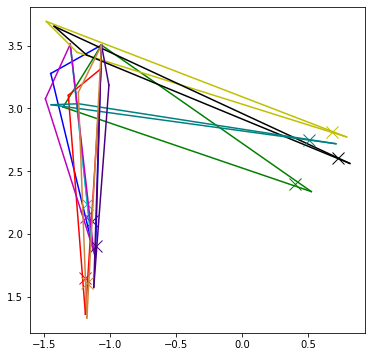

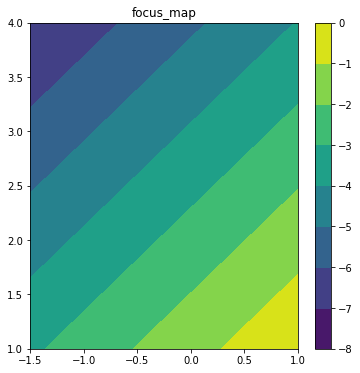

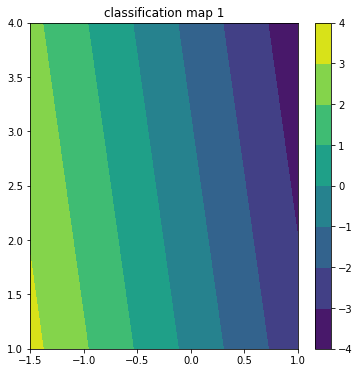

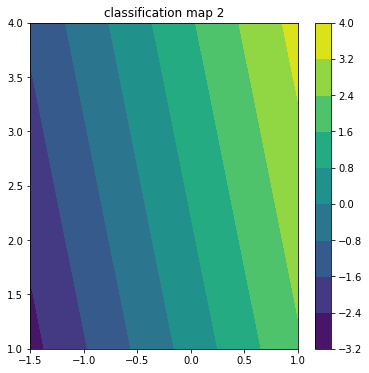

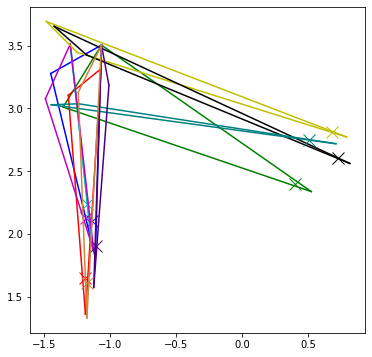

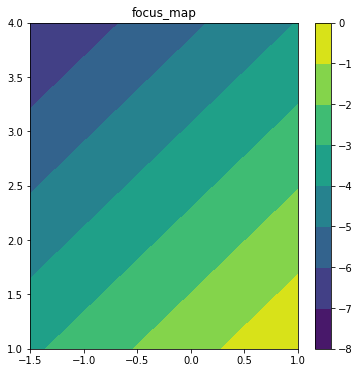

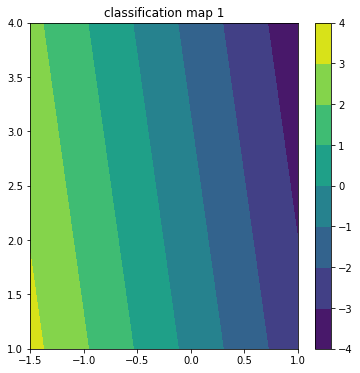

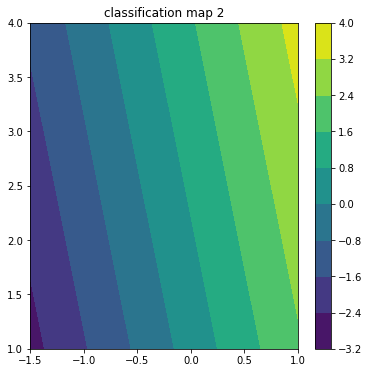

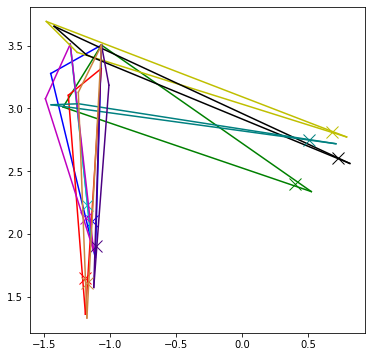

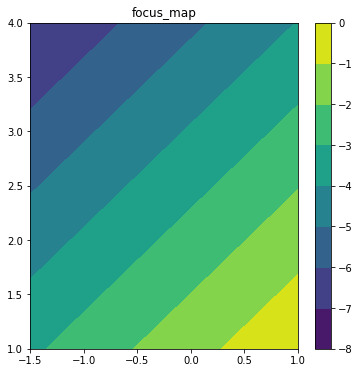

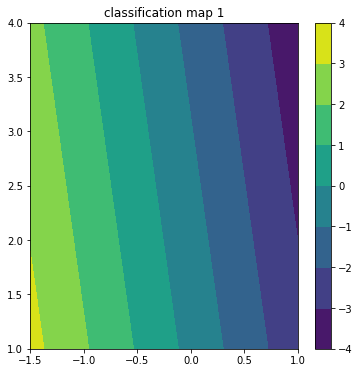

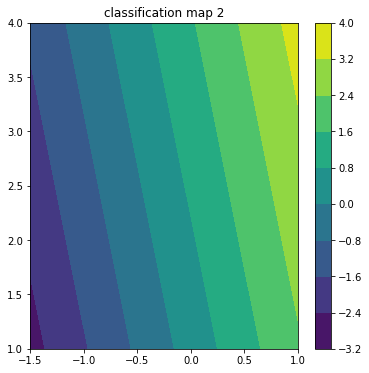

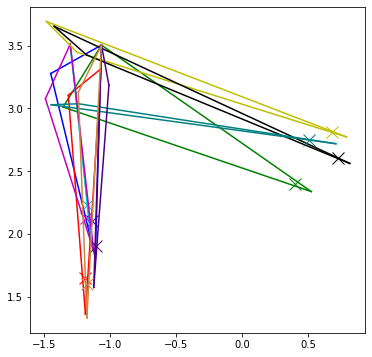

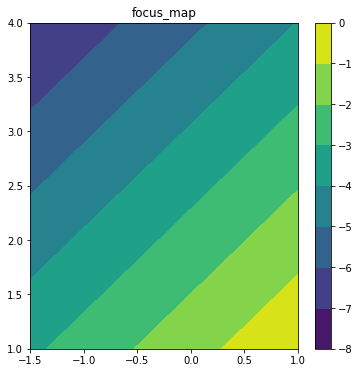

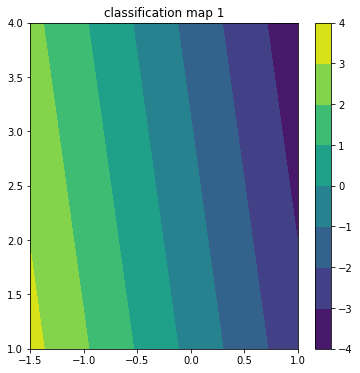

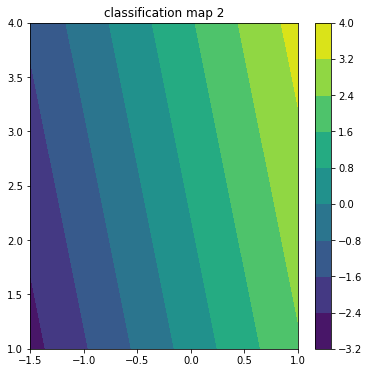

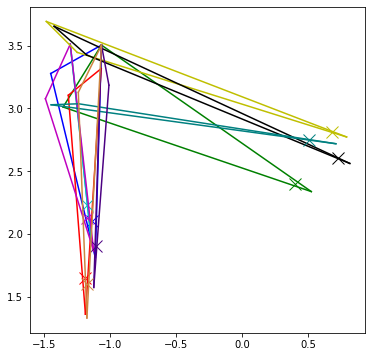

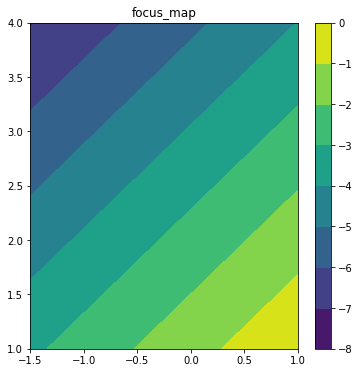

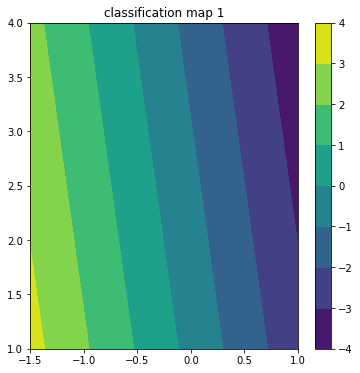

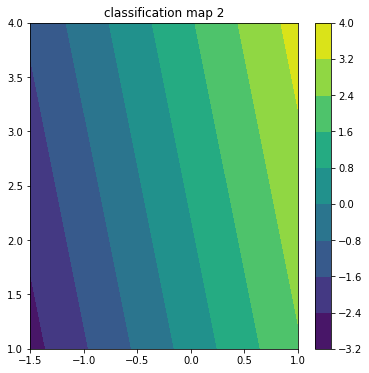

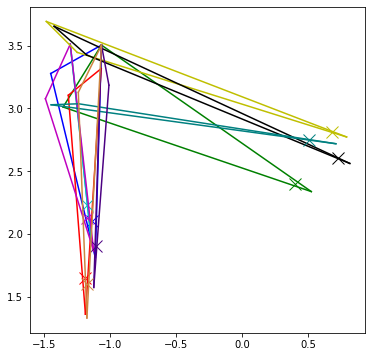

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01, momentum=0.9)




nos_epochs = 100

train_loss=[]

train_acc = [] 
ig = np.random.randint(0,250)
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    avg11_inp = []
    avg11_label = [] 
    running_loss = 0.0
    running_acc = 0
    cnt=0
    c = 0
    iteration = desired_num // batch
    focus_map(where)  # visualize contour map for focus net

    classification_map(what)  # visualise contourmap for classification net
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        avg11_inp.append(avg_inp.detach().numpy())
        avg11_label.append(labels.numpy())
        if(c==0):
           
            disp_plot(inputs[:10,:],avg_inp[:10],labels[:10].numpy()
                      ,predicted[:10].numpy(), avg_inp[:10,:], fore_idx[:10].numpy())
            
            
            c+=1
            
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        running_acc+=sum(predicted.cpu().numpy()== labels.cpu().numpy())
        
        if cnt % 4 == 3:    # print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss/4 ))
            print('[%d,%5d] accuracy: %.3f' %(epoch + 1, cnt+1,running_acc/1000))
            
            train_loss.append(running_loss)
            train_acc.append(running_acc /1000)
            running_loss = 0.0
            running_acc = 0
            
            #torch.save(where.state_dict(),"weight_elemental_2/where_model_epoch"+str(epoch)+".pt")
            #torch.save(what.state_dict(),"weight_elemental_2/what_model_epoch"+str(epoch)+".pt")
        cnt=cnt+1
        
print('Finished Training')
#torch.save(where.state_dict(),"weight_elemental_2/where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"weight_elemental_2/what_model_epoch"+str(epoch)+".pt")       
        
        
        

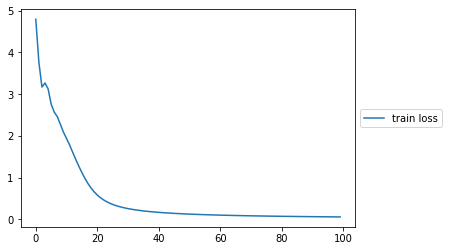

In [27]:
plt.plot(train_loss,label = "train loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

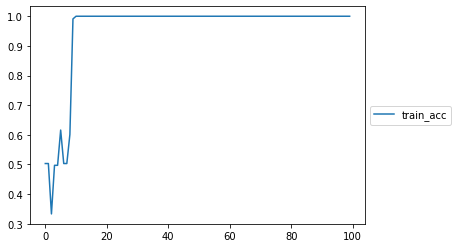

In [28]:
plt.plot(train_acc,label ="train_acc")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [0]:
dat = np.concatenate(avg11_inp,axis=0)

In [0]:
lbls = np.concatenate(avg11_label,axis=0)

In [31]:
dat[:,0].shape

(1000,)

In [0]:
# plt.scatter(dat[lbls==0,0],dat[lbls==0,1],label = "fg0")
# plt.scatter(dat[lbls==1,0],dat[lbls==1,1],label = "fg1")
# plt.legend()